In [3]:
import json
import base64

# Load from a JSON file
with open("logos_dict.json", "r") as json_file:
    loaded_encoded_logos_dict = json.load(json_file)

# Decode the image data back to binary
decoded_logos_dict = {domain: base64.b64decode(img_bytes) for domain, img_bytes in loaded_encoded_logos_dict.items()}

In [16]:
from PIL import Image
import io

# Function to check if the binary data is a valid image
def is_valid_image(img_bytes):
    try:
        # Try to open the binary data as an image
        img = Image.open(io.BytesIO(img_bytes))
        img.verify()  # Verify the image file integrity
        return True
    except Exception:
        return False

# Filter decoded_logos_dict to keep only valid images
filtered_logos_dict = {
    domain: img_bytes
    for domain, img_bytes in decoded_logos_dict.items()
    if img_bytes is not None and is_valid_image(img_bytes)
}

print(f"Prior total number of logos: {len(decoded_logos_dict)}")
print(f"Number of filtered logos: {len(filtered_logos_dict)}")

Prior total number of logos: 3360
Number of filtered logos: 3336


In [ ]:
from itertools import combinations
from skimage.metrics import structural_similarity as ssim
import numpy as np

# Function to convert image bytes to a consistent-sized NumPy array
def bytes_to_image_array(img_bytes, target_size=(256, 256)):
    img = Image.open(io.BytesIO(img_bytes)).convert("L")  # Convert to grayscale
    img_resized = img.resize(target_size)  # Resize to target dimensions
    return np.array(img_resized)

# Preprocess images into a dictionary of resized NumPy arrays
target_size = (256, 256)  # Define a consistent size for all images
image_arrays = {
    domain: bytes_to_image_array(img_bytes, target_size)
    for domain, img_bytes in filtered_logos_dict.items()
}

# Compare each pair without repeating
ssim_results = {}
for (domain1, img1), (domain2, img2) in combinations(image_arrays.items(), 2):  # Use combinations to avoid duplicates
    score = ssim(img1, img2)  # Calculate SSIM
    ssim_results[(domain1, domain2)] = score  # Store the result

In [ ]:
# Convert tuple keys to strings
formatted_ssim_results = {str(key): value for key, value in ssim_results.items()}

# Save the similarity matrix to a JSON file
with open("similarity_matrix.json", "w") as json_file:
    json.dump(formatted_ssim_results, json_file)

In [4]:
# Load the JSON file
with open("similarity_matrix.json", "r") as json_file:
    loaded_data = json.load(json_file)

# Convert string keys back to tuples
original_ssim_results = {eval(key): value for key, value in loaded_data.items()}

In [33]:
import networkx as nx
import json

# Load the similarity matrix from the JSON file
with open("similarity_matrix.json", "r") as json_file:
    loaded_data = json.load(json_file)

# Convert string keys back to tuples
original_ssim_results = {eval(key): value for key, value in loaded_data.items()}

# Step 1: Create a graph and add all logos as nodes
graph = nx.Graph()
graph.add_nodes_from([logo for pair in original_ssim_results.keys() for logo in pair])

# Step 2: Add edges for logo pairs with SSIM > threshold
threshold = 0.99
for (logo1, logo2), score in original_ssim_results.items():
    if score > threshold:
        graph.add_edge(logo1, logo2)

# Step 3: Find connected components (each component is a cluster)
clusters = [list(component) for component in nx.connected_components(graph)]

# Step 4: Print the number of clusters and the total number of logos across all clusters
print(f"Number of groups: {len(clusters)}")

Number of groups: 2078


In [35]:
# Save the similarity matrix to a JSON file
with open("best_result.json", "w") as json_file:
    json.dump(clusters, json_file)

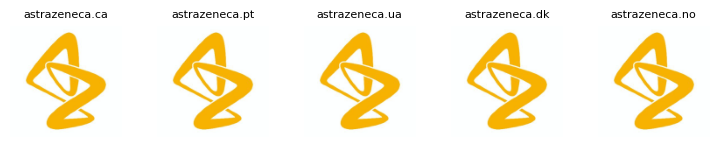

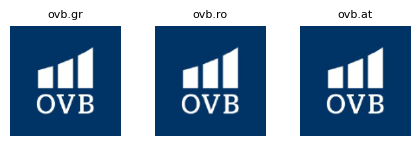

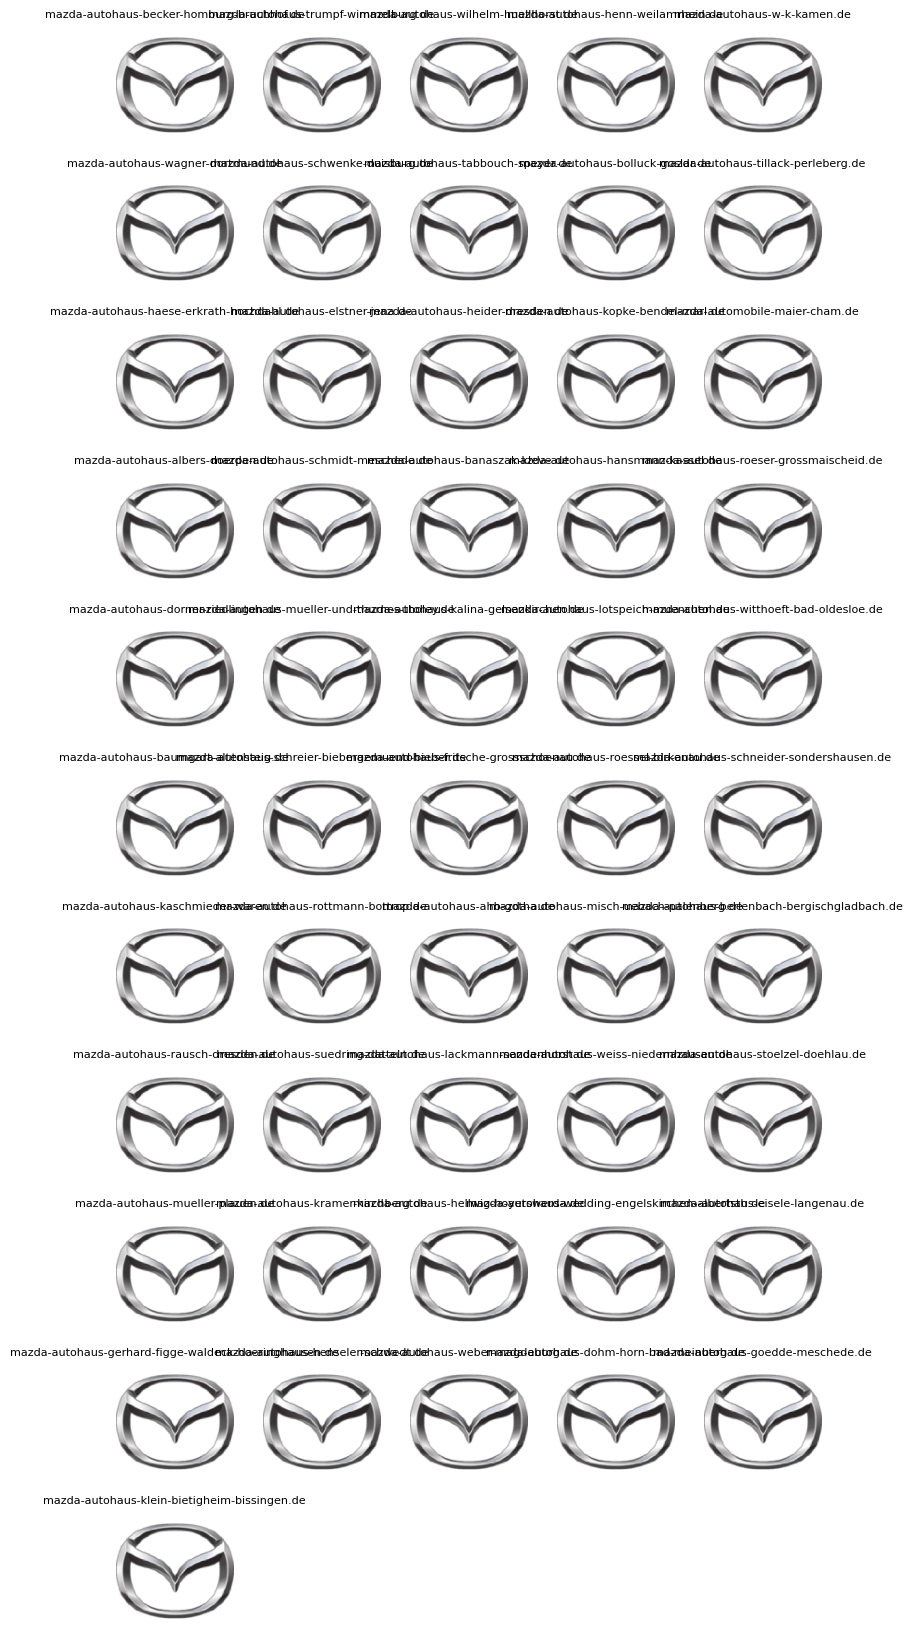

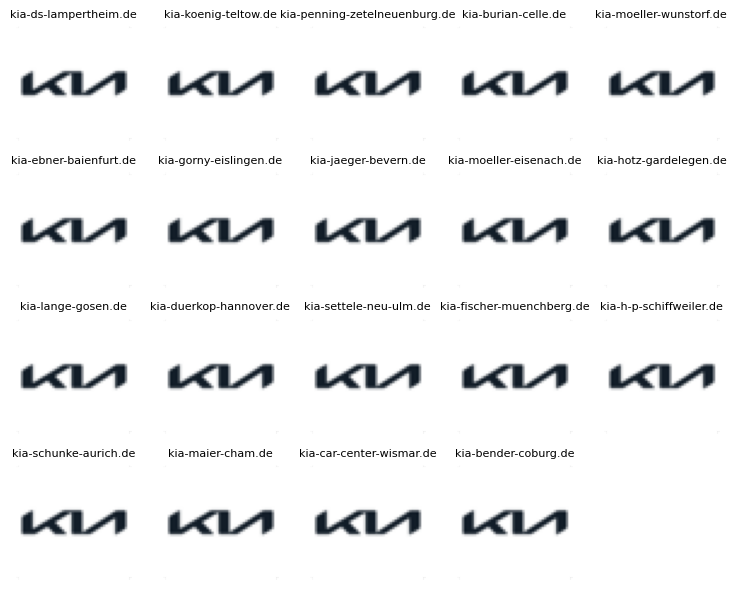

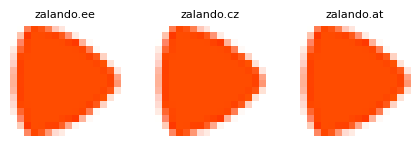

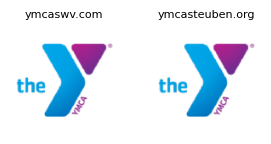

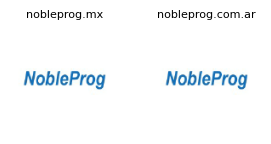

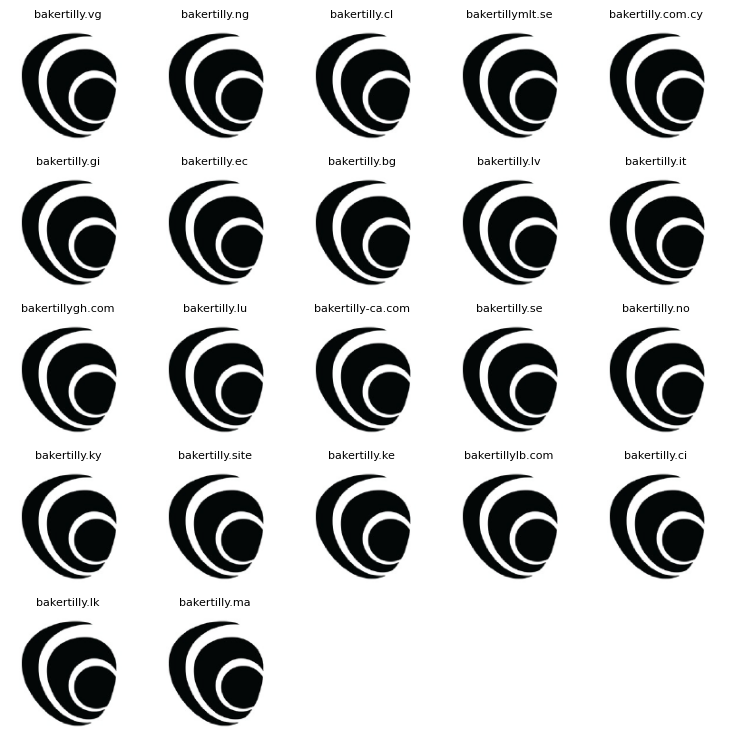

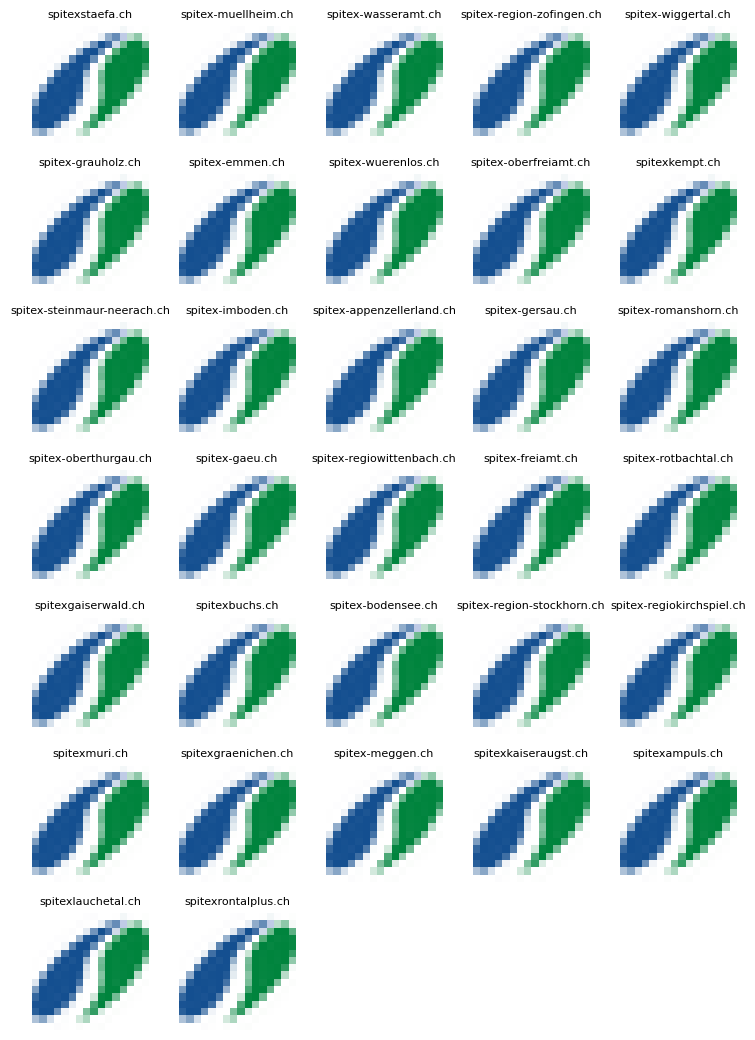

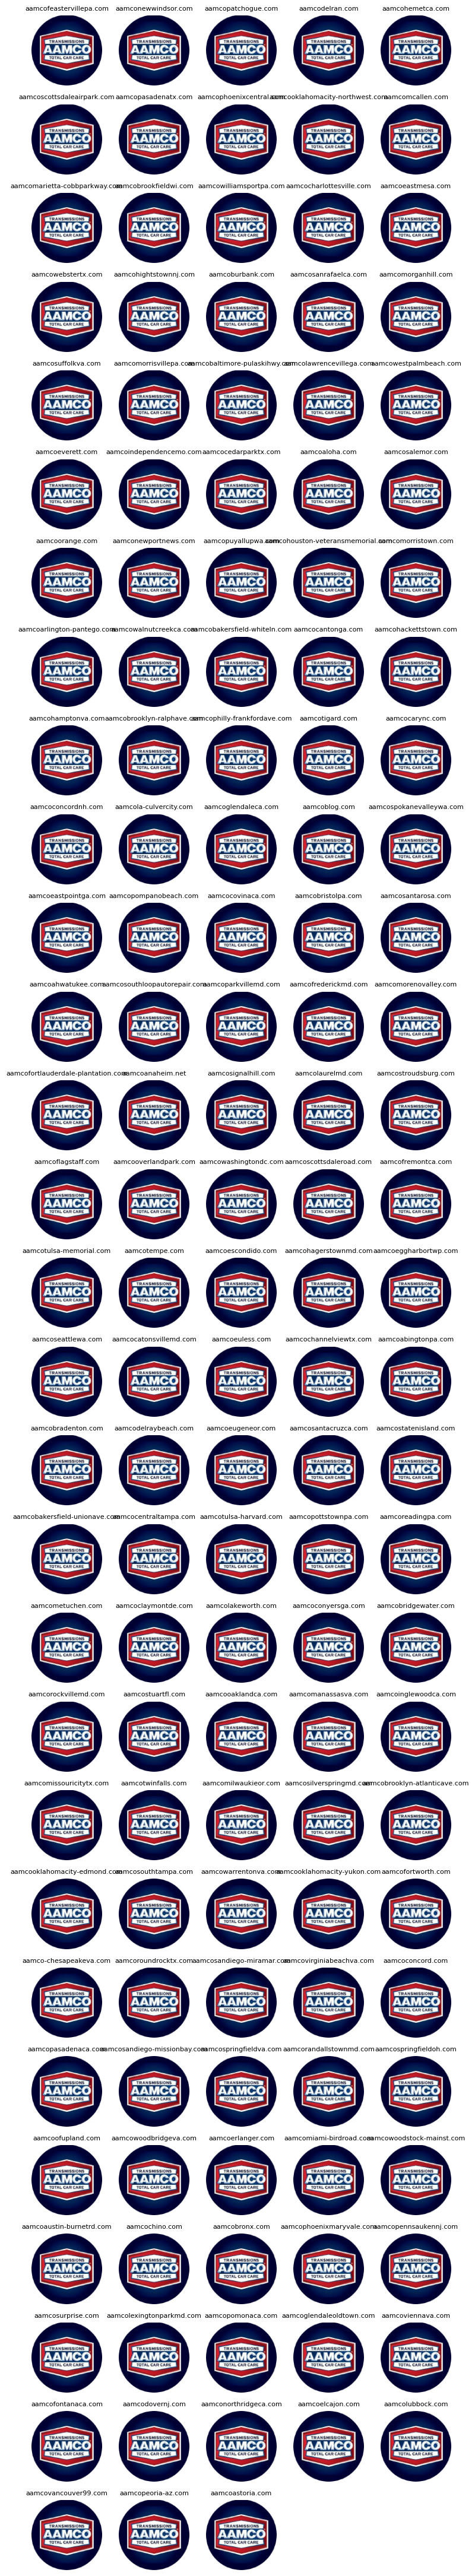

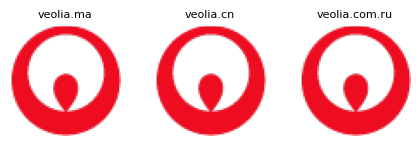

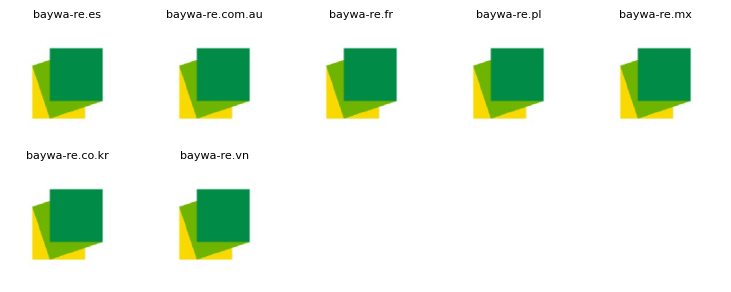

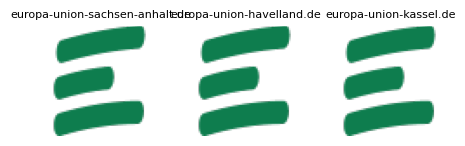

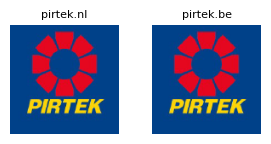

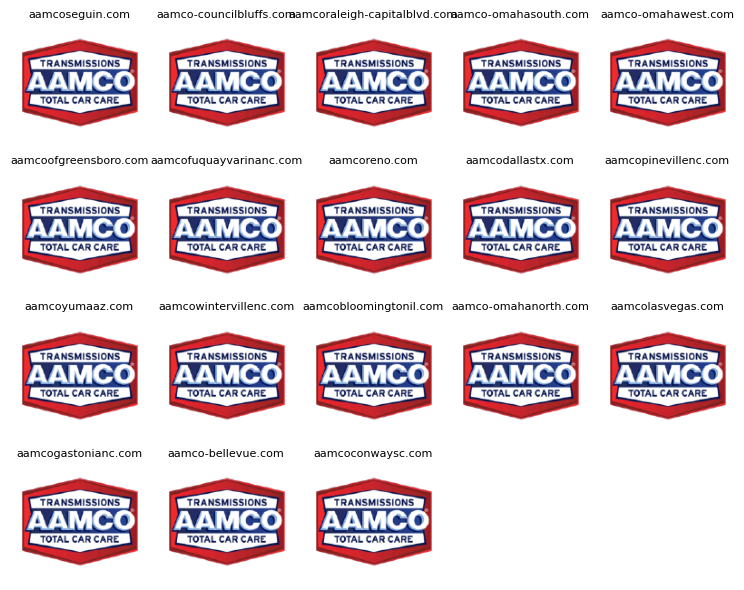

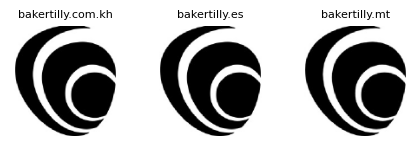

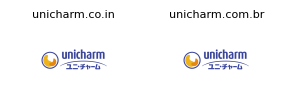

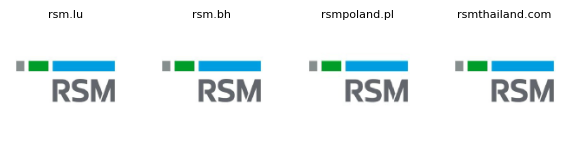

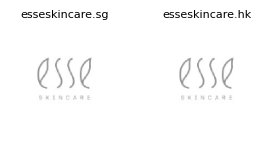

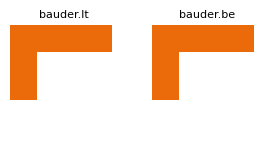

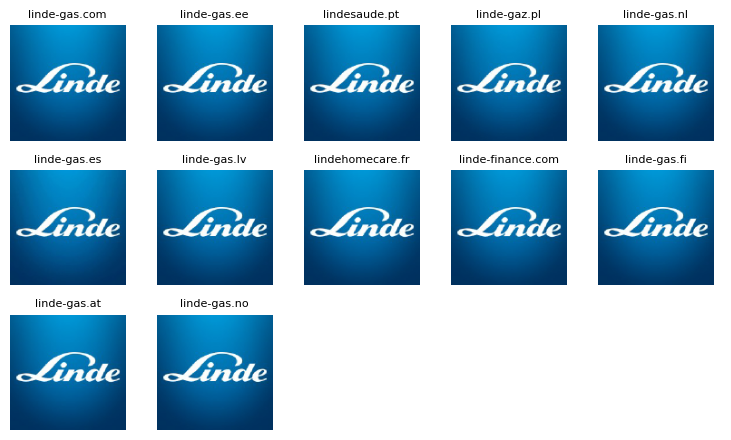

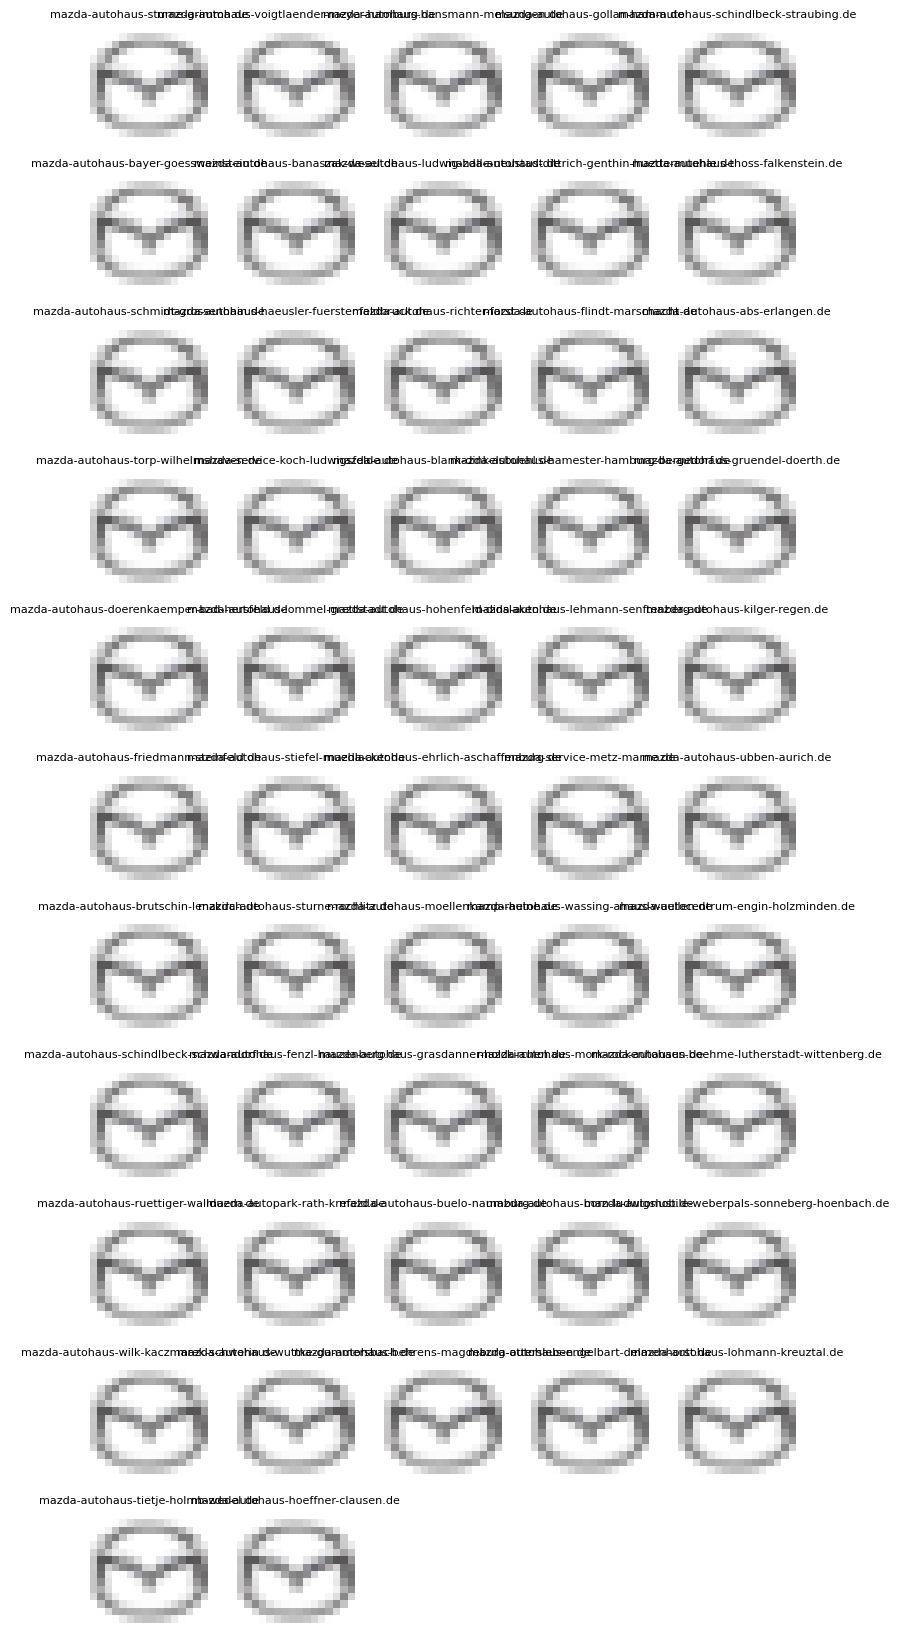

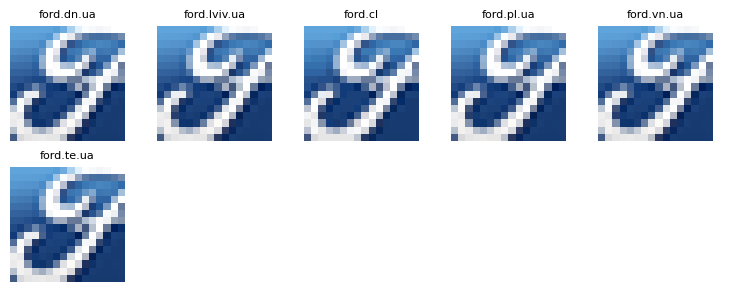

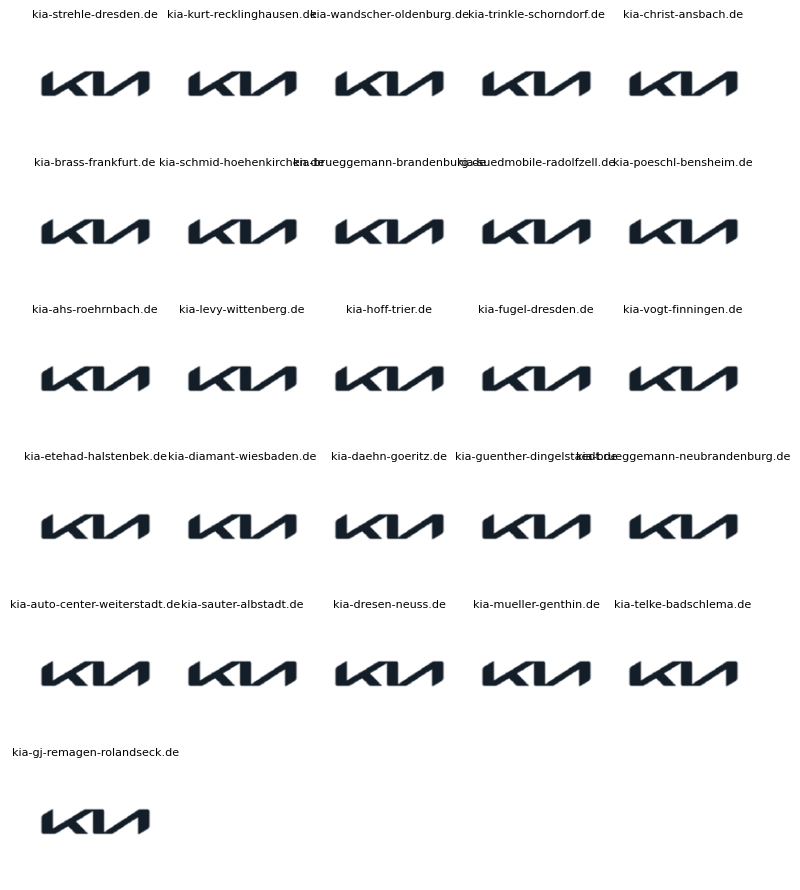

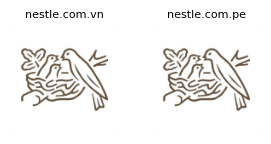

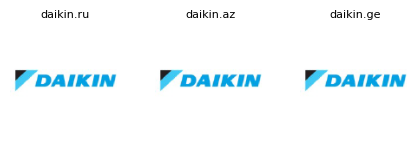

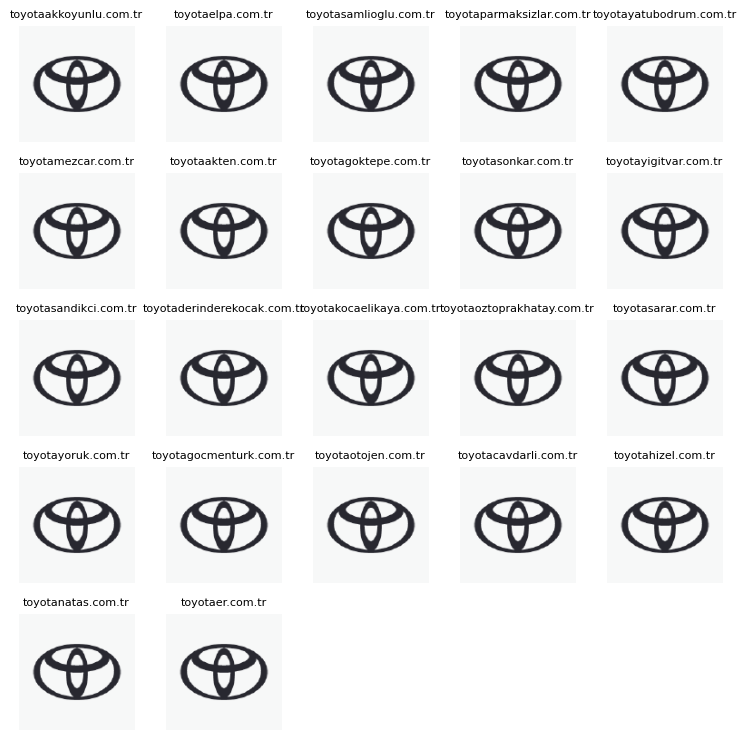

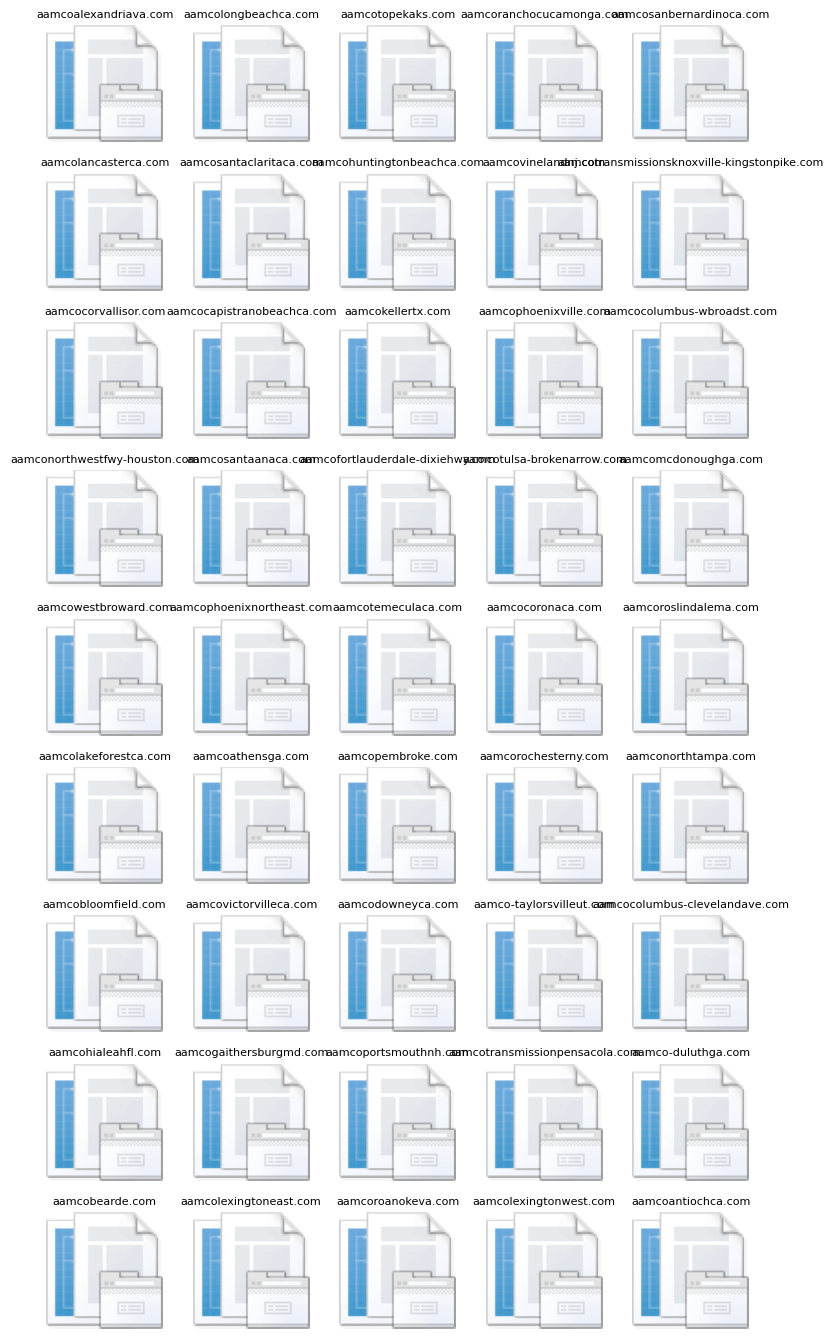

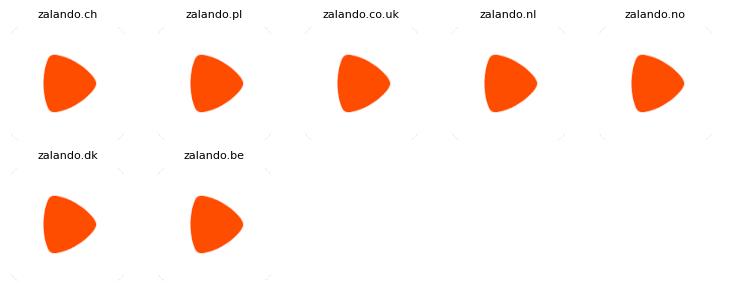

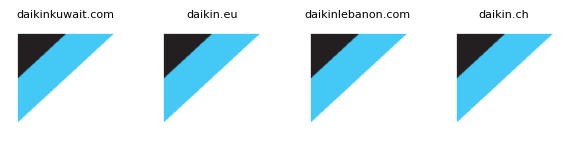

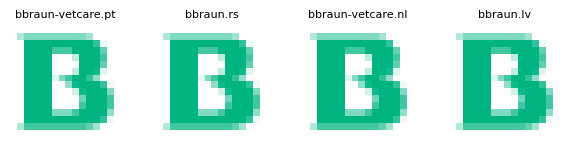

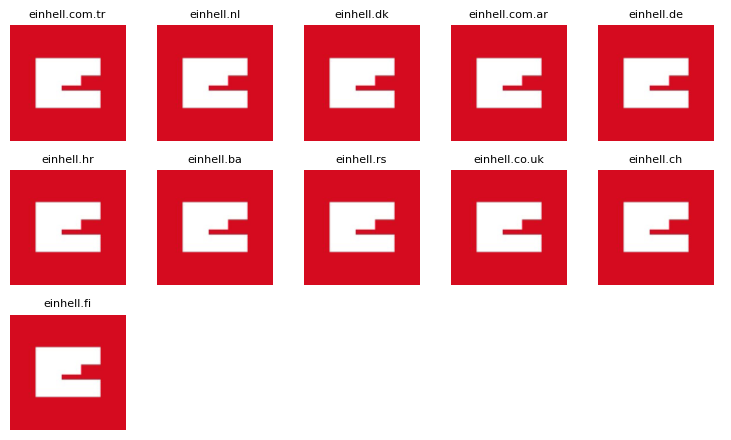

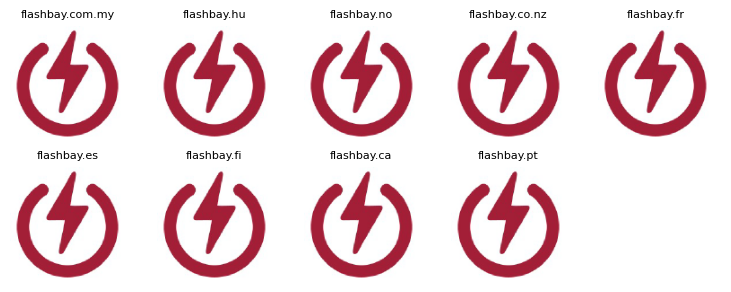

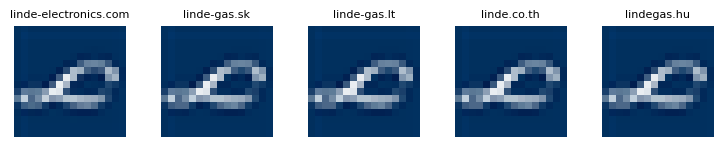

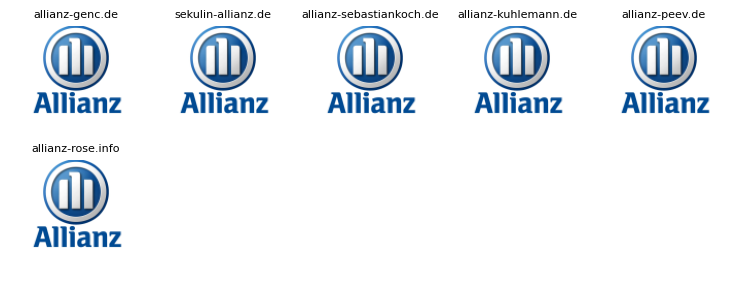

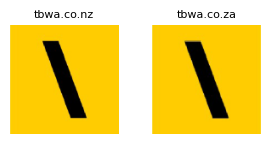

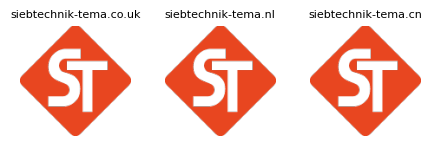

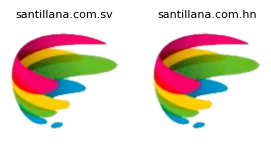

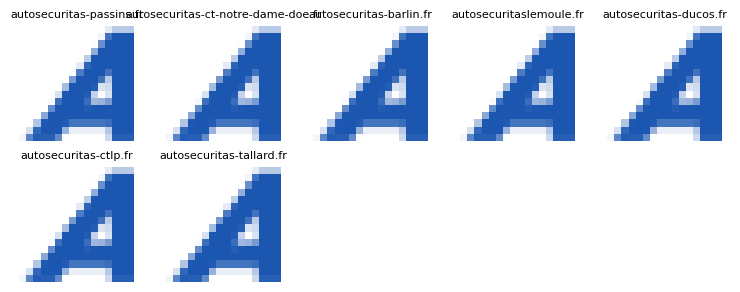

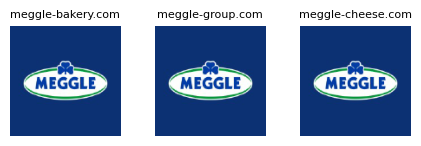

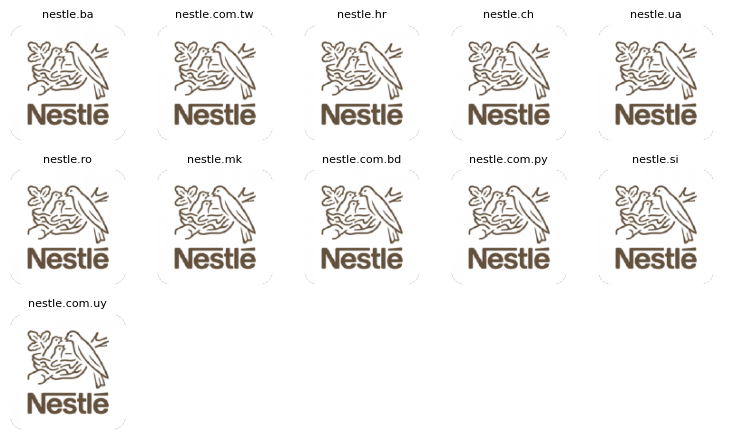

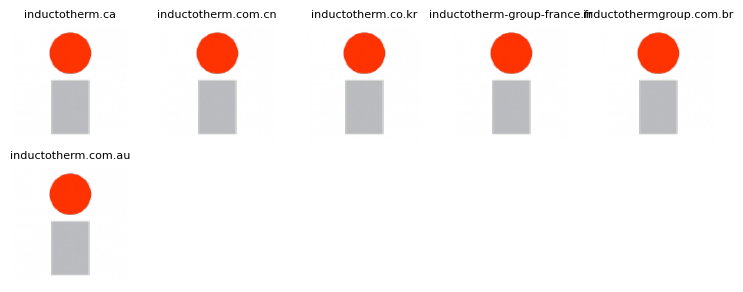

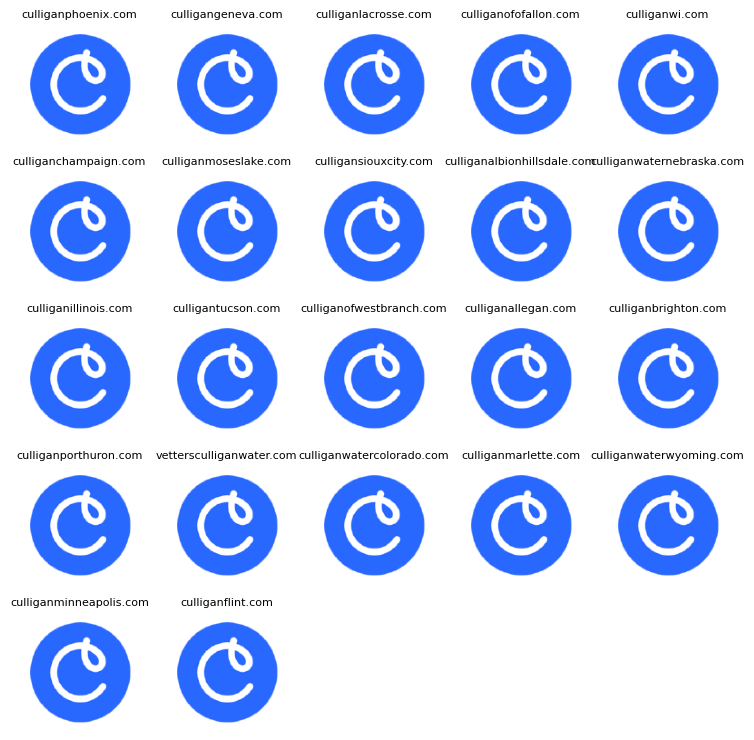

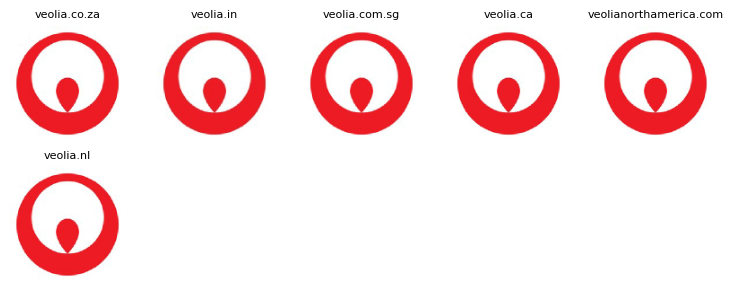

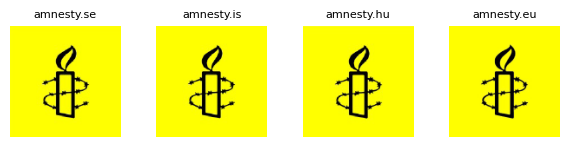

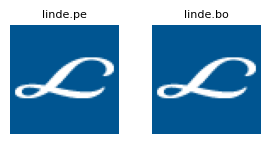

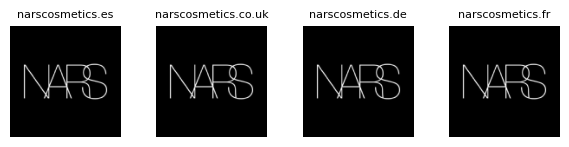

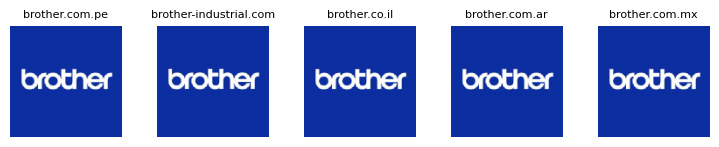

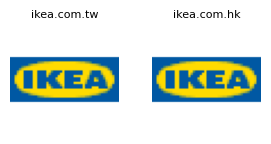

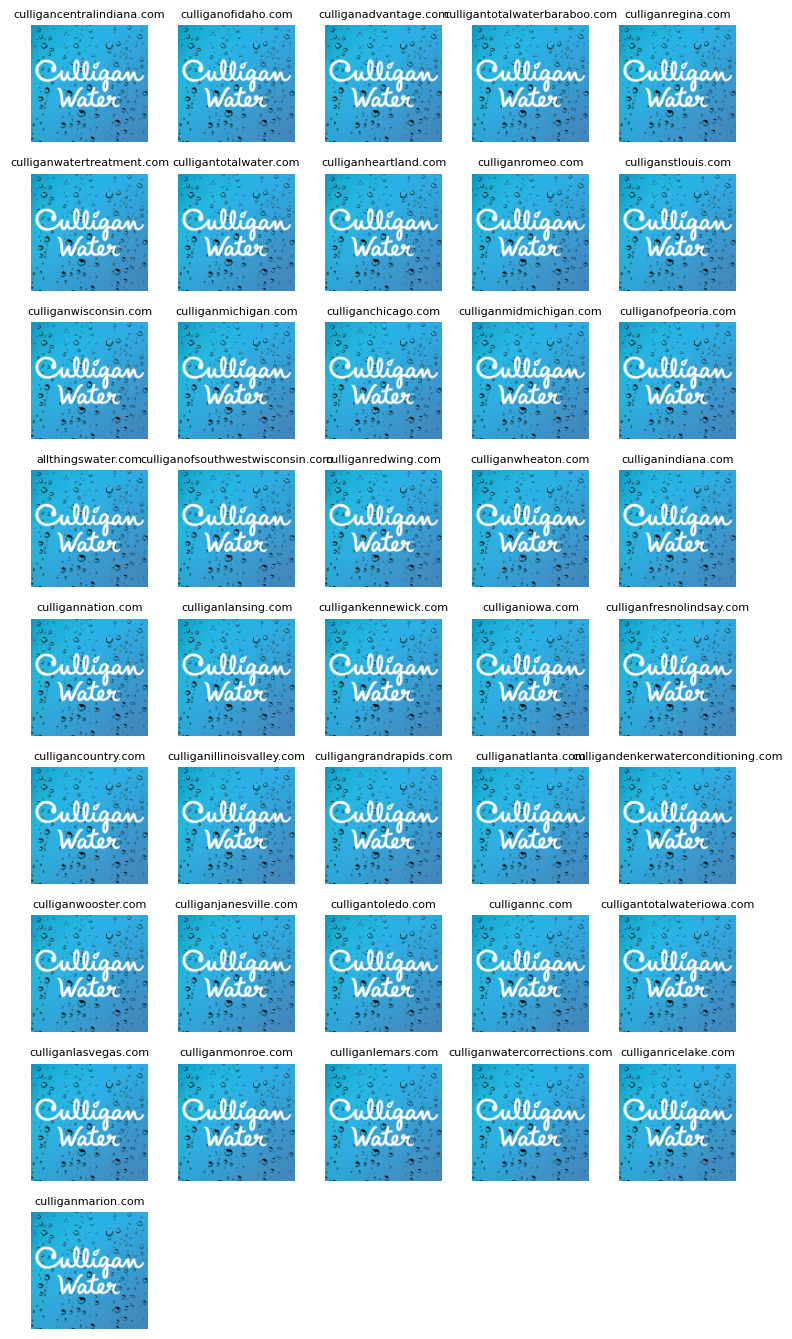

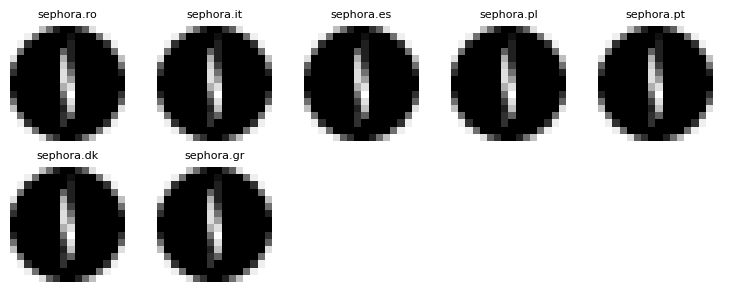

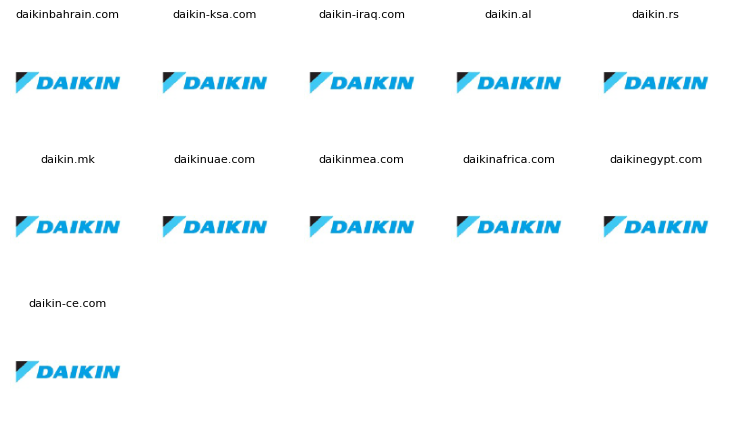

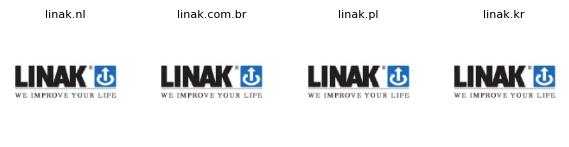

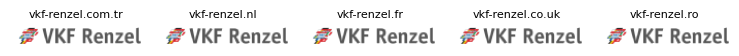

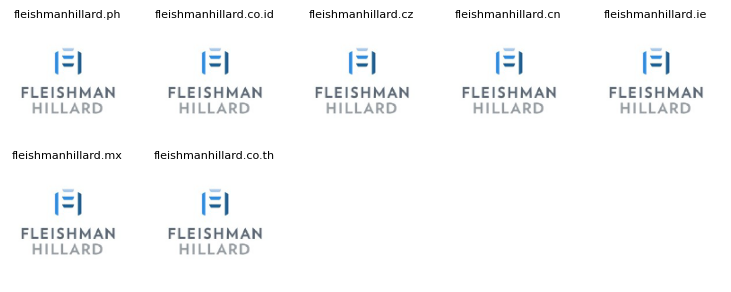

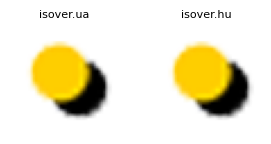

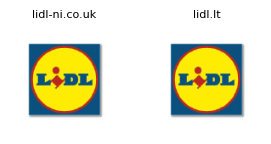

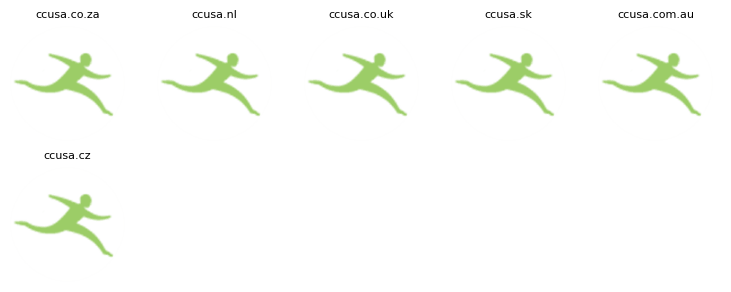

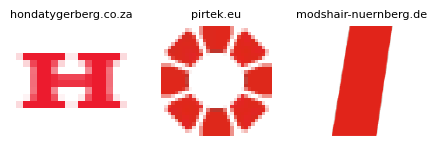

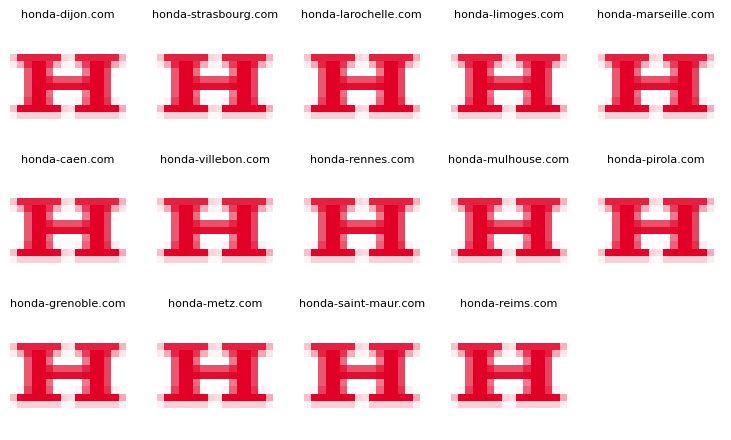

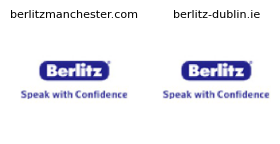

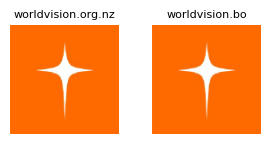

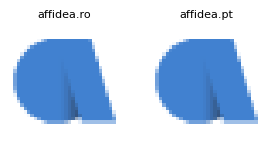

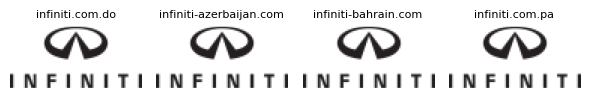

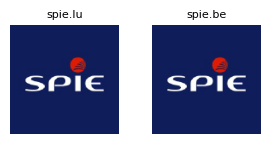

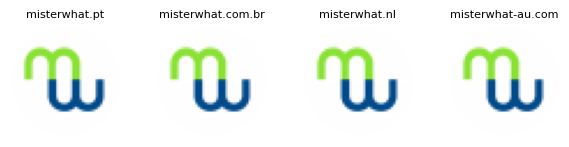

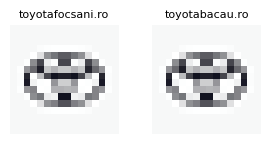

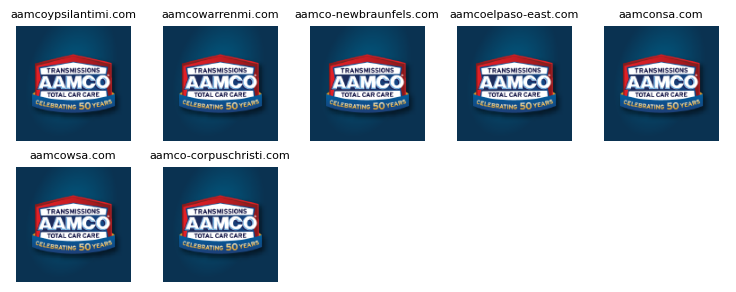

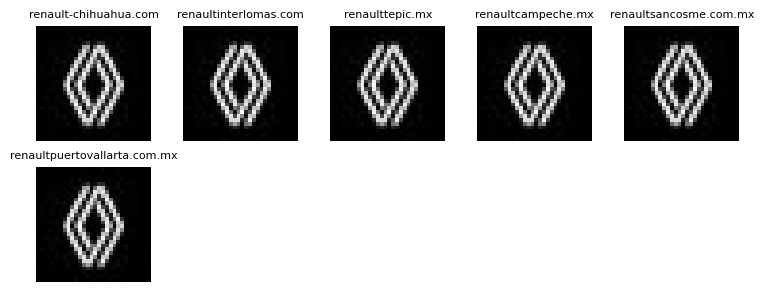

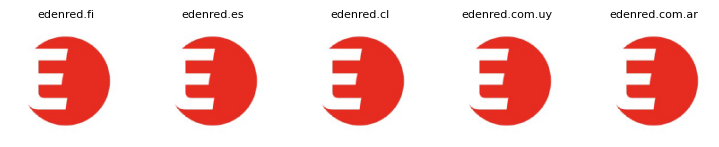

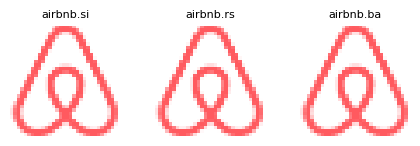

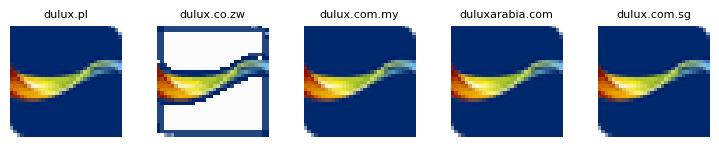

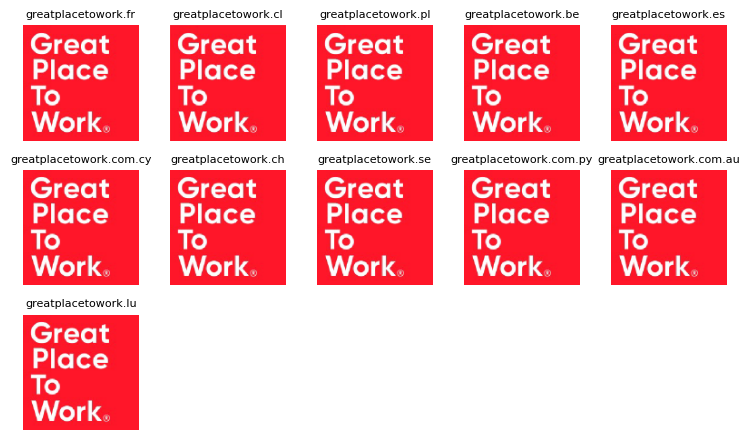

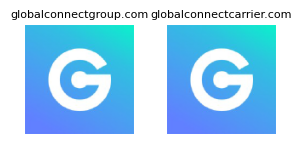

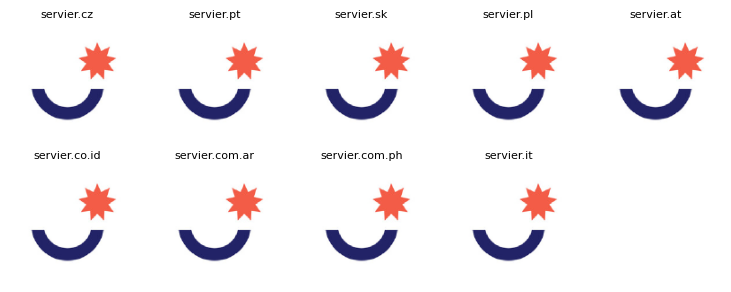

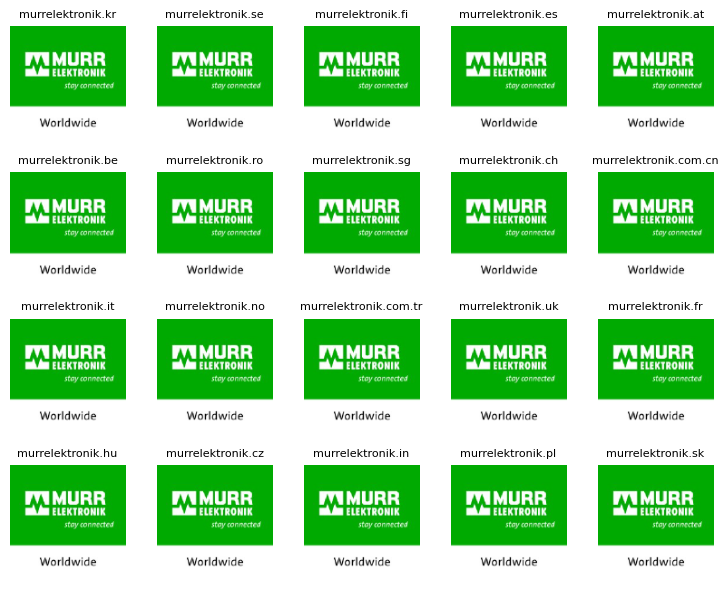

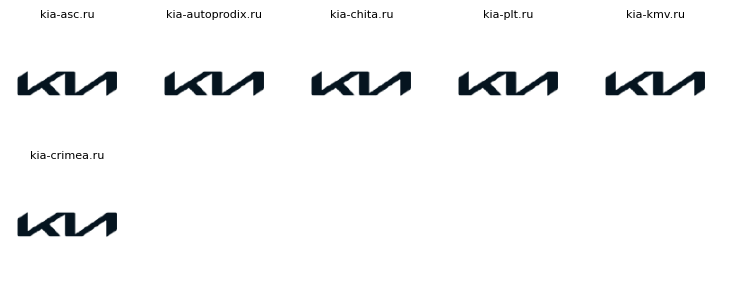

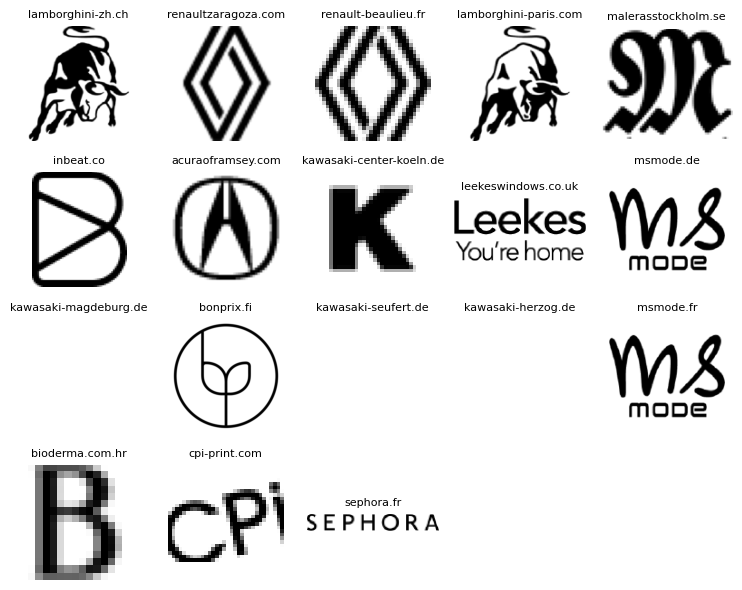

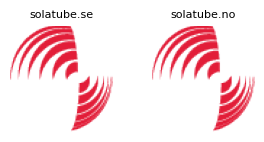

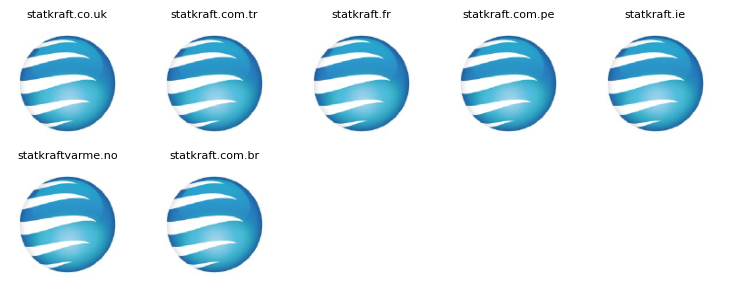

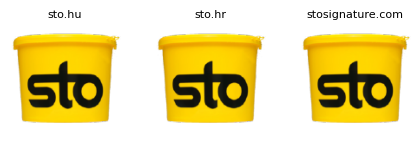

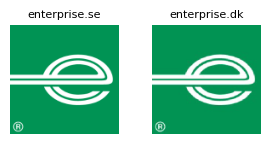

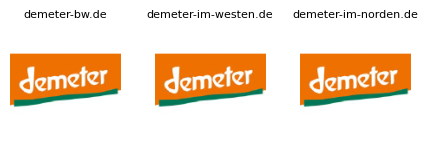

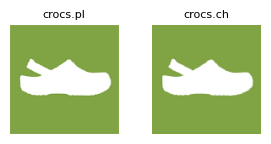

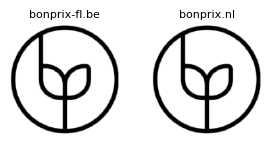

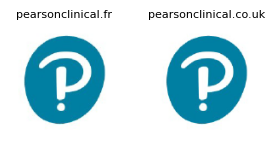

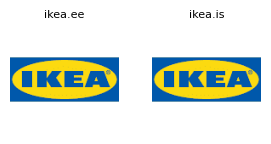

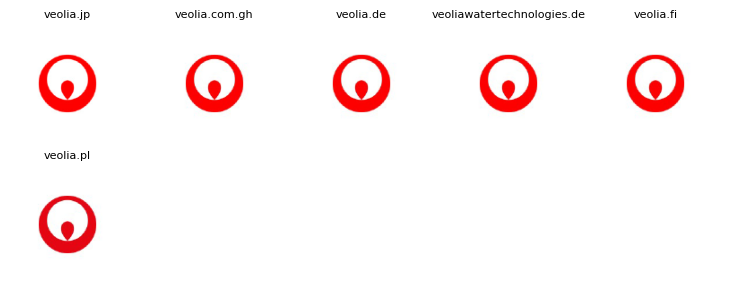

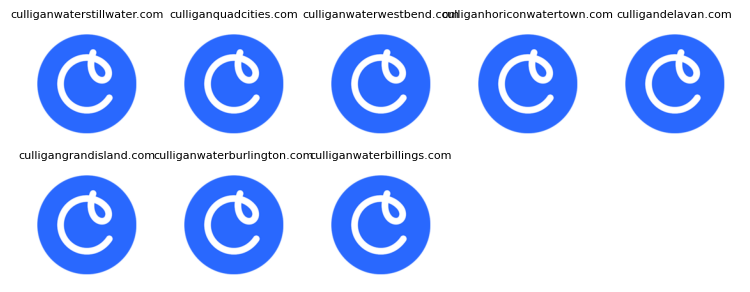

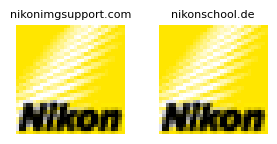

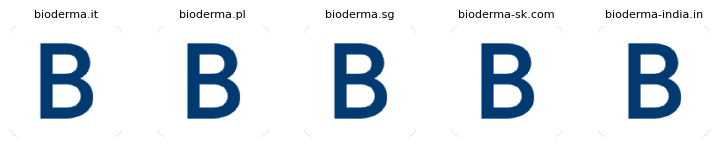

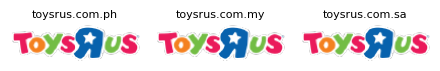

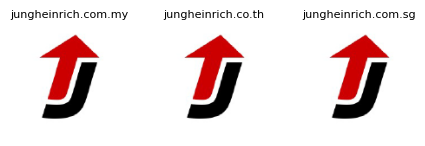

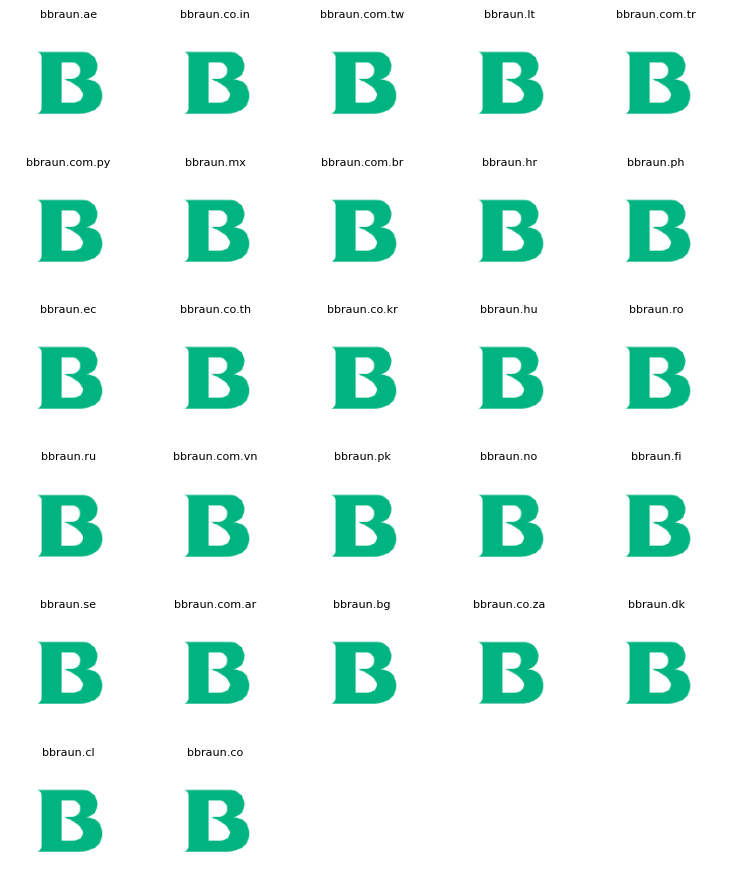

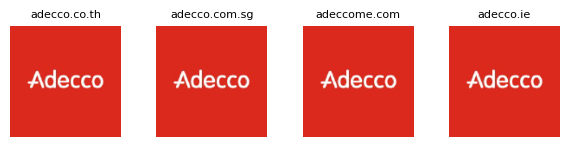

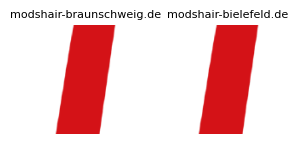

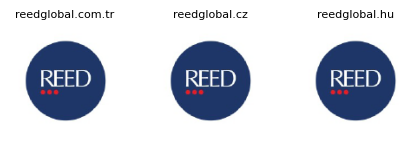

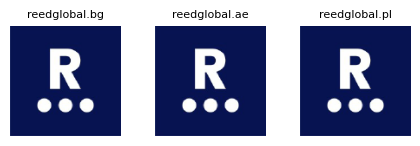

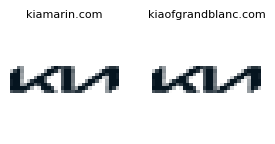

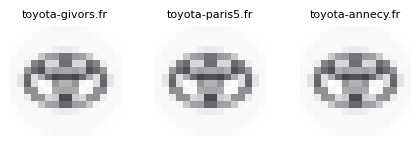

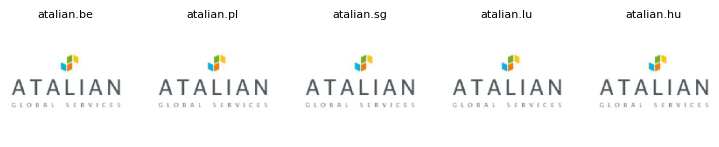

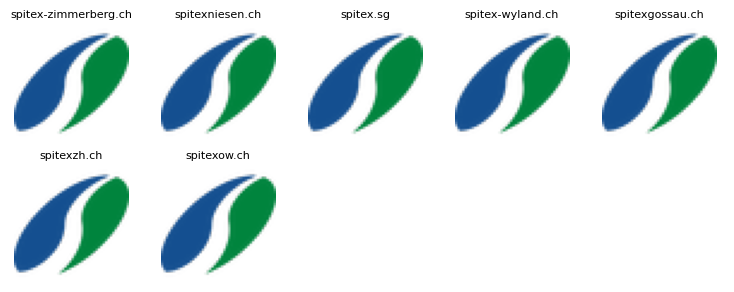

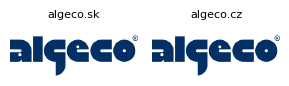

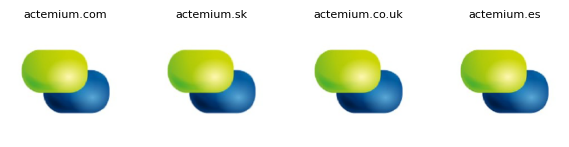

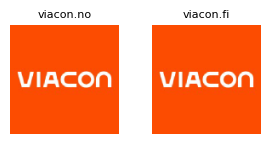

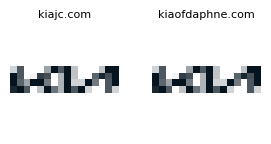

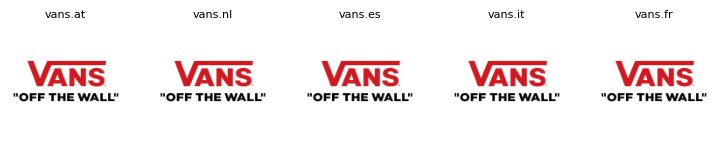

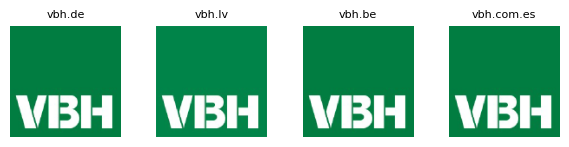

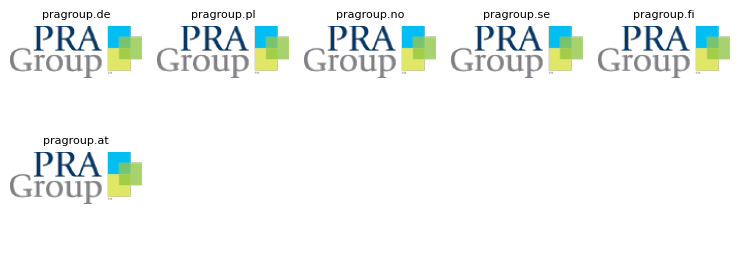

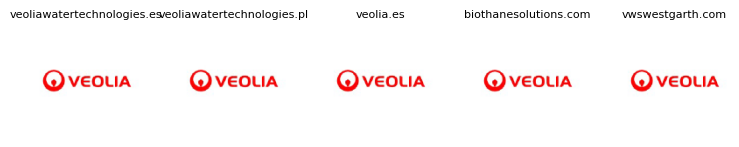

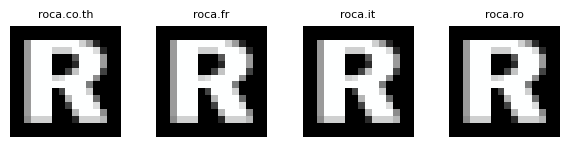

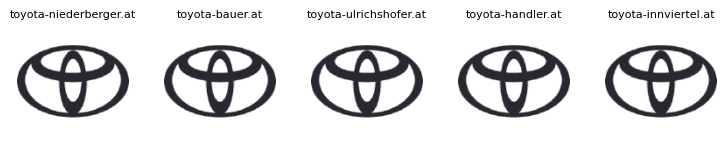

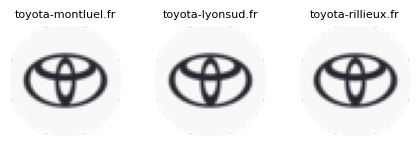

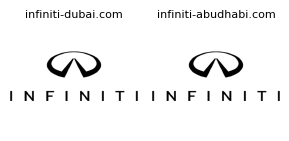

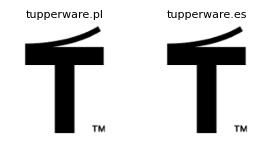

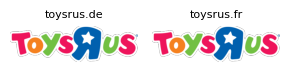

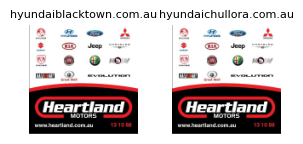

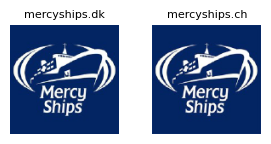

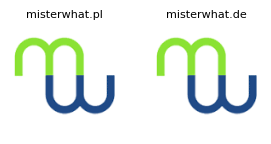

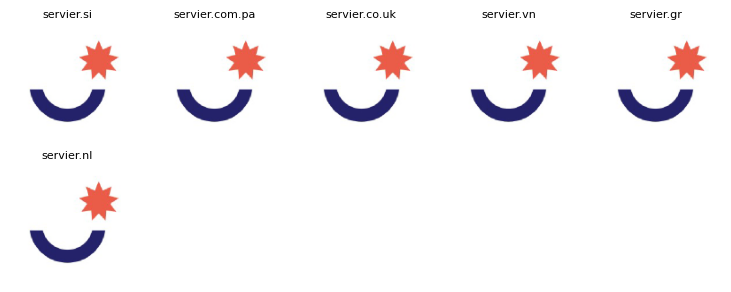

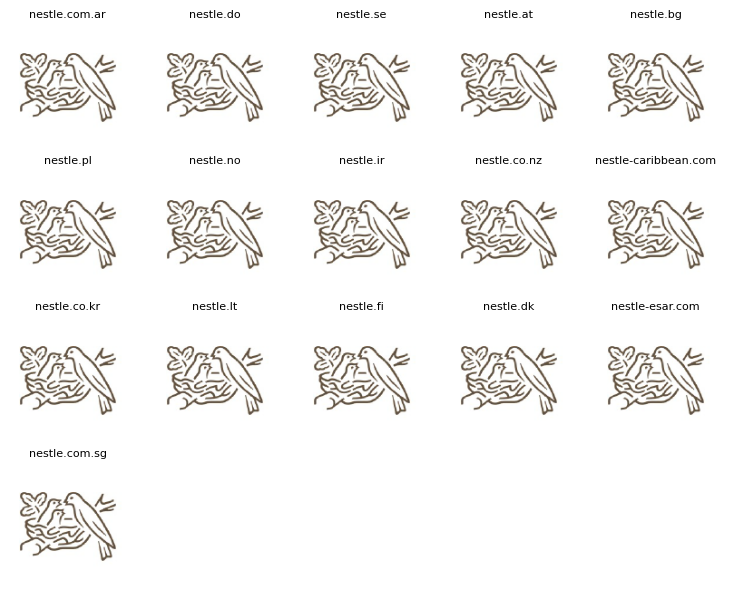

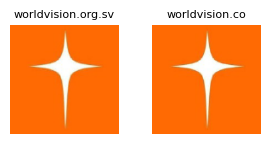

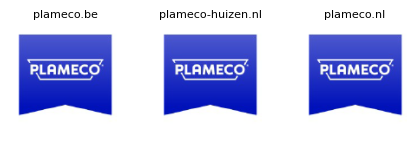

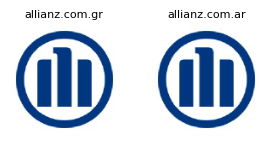

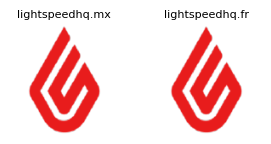

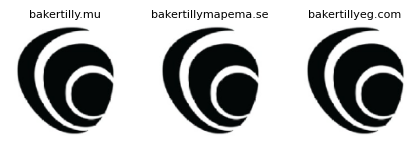

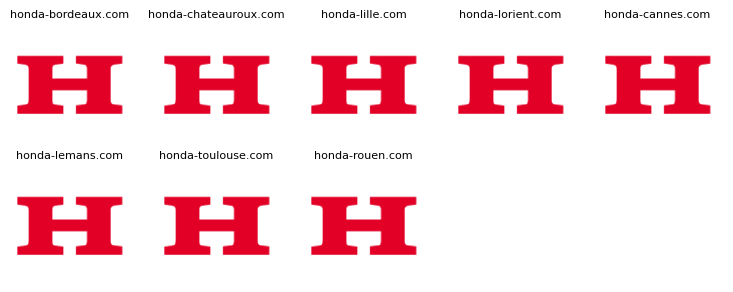

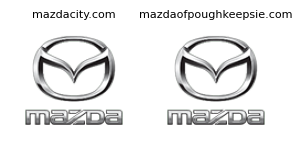

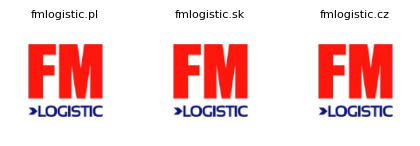

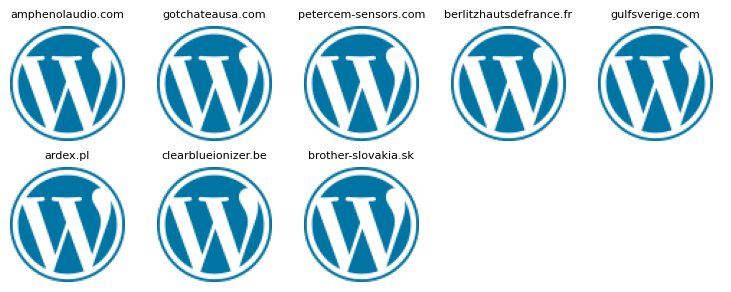

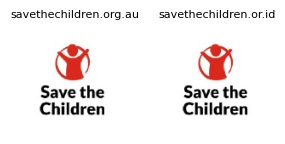

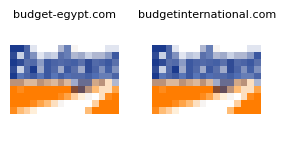

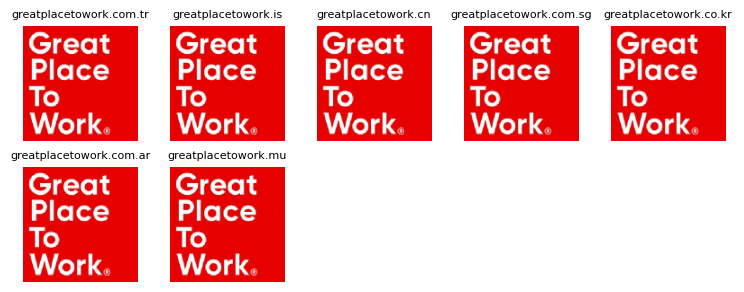

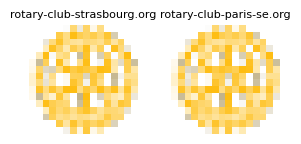

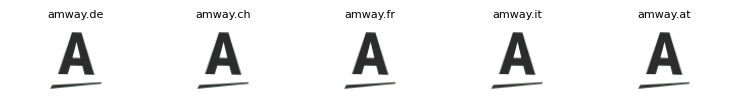

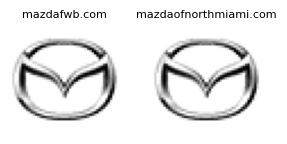

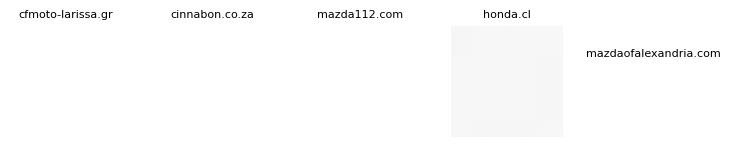

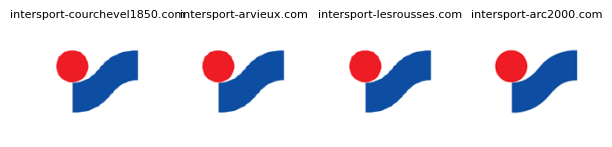

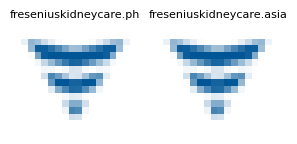

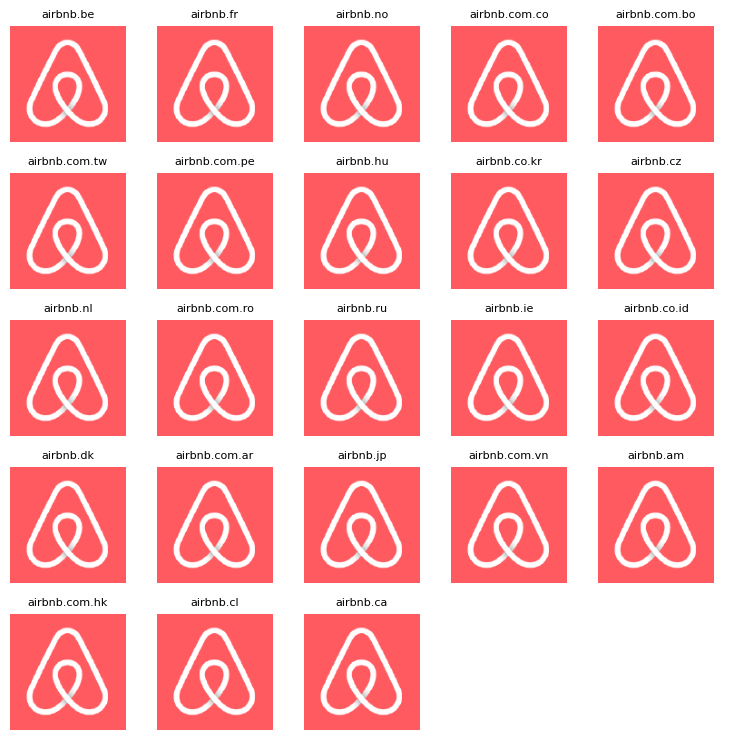

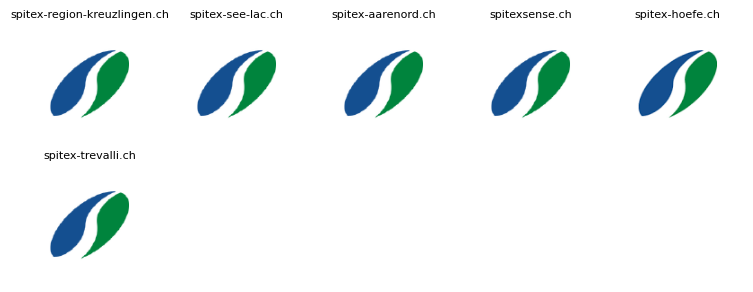

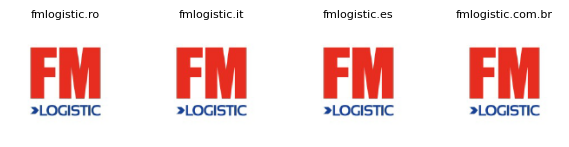

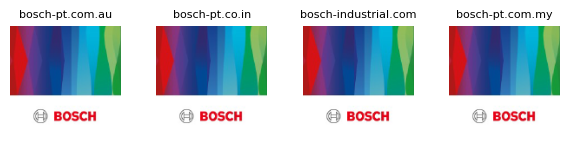

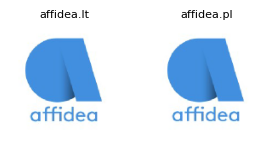

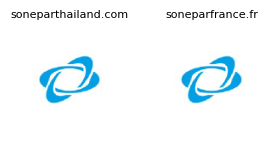

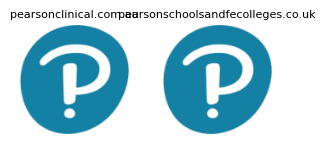

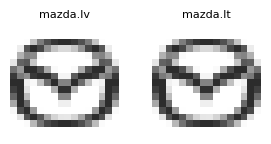

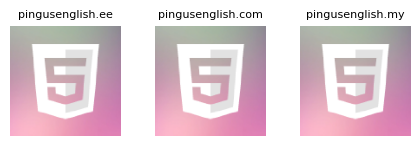

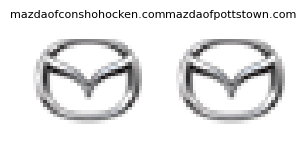

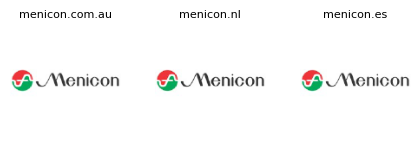

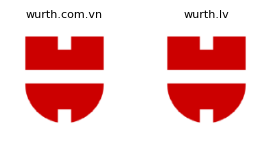

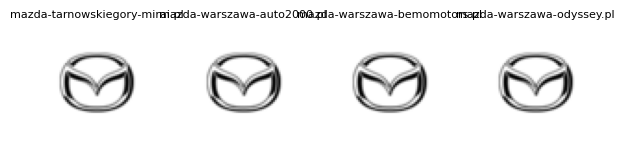

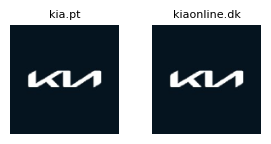

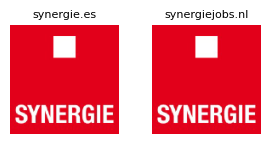

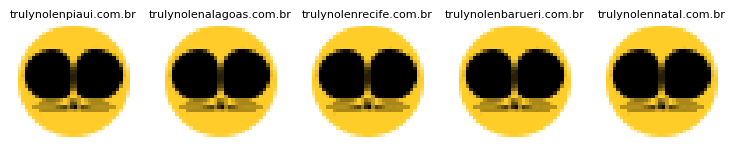

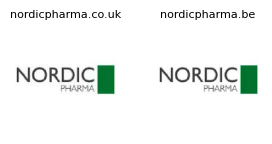

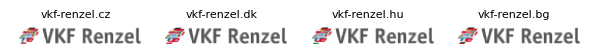

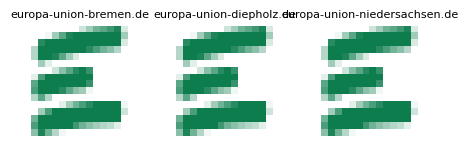

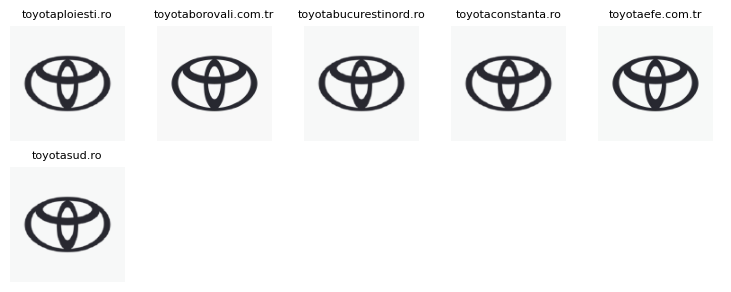

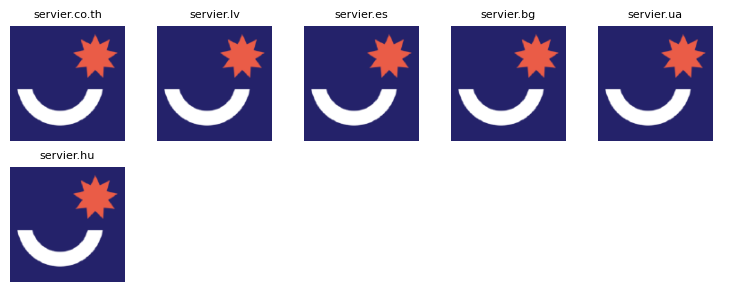

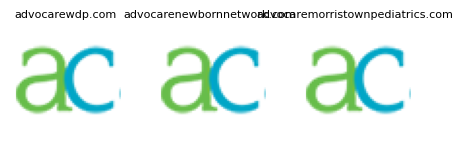

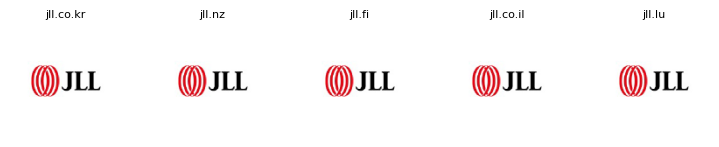

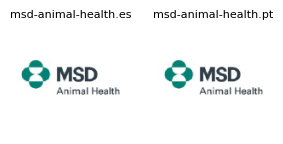

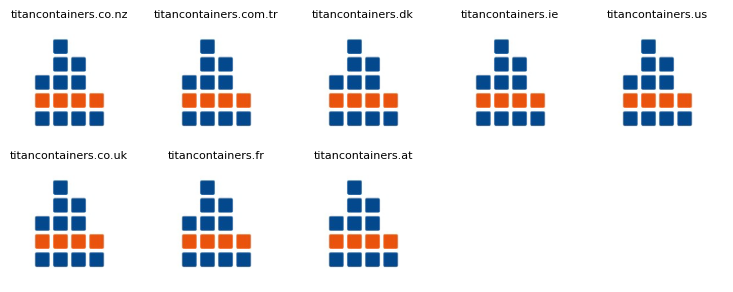

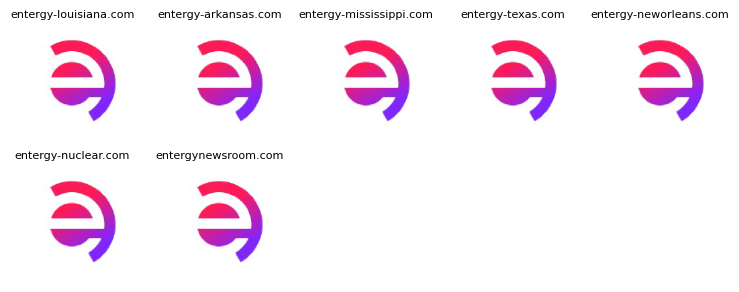

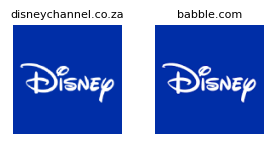

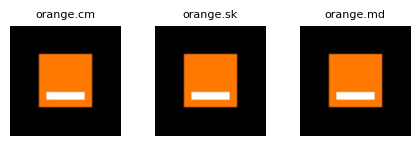

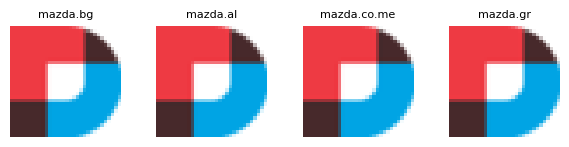

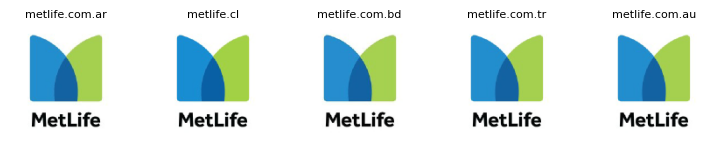

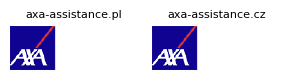

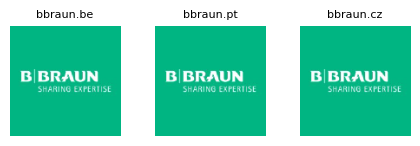

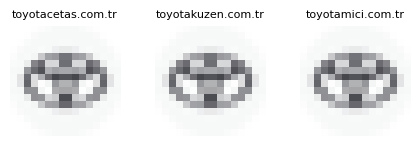

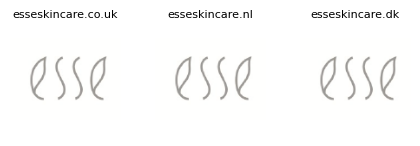

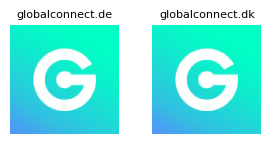

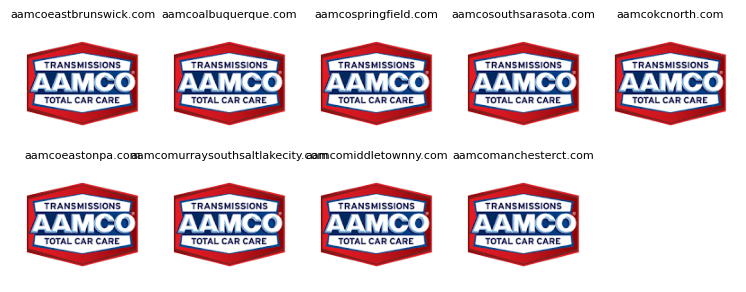

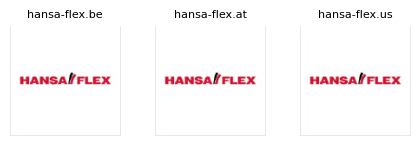

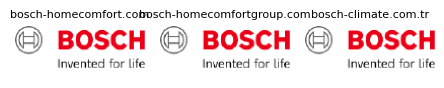

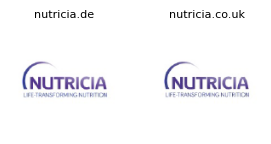

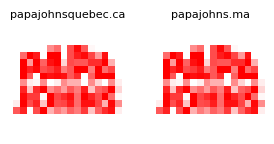

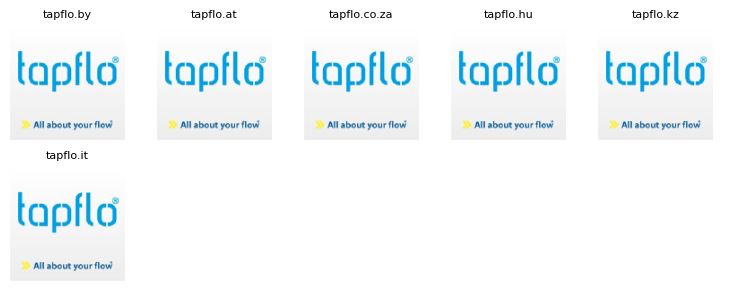

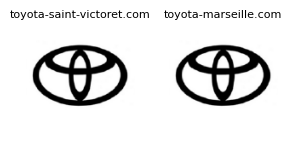

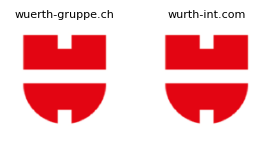

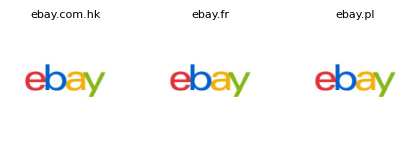

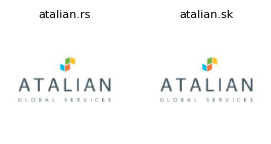

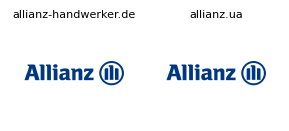

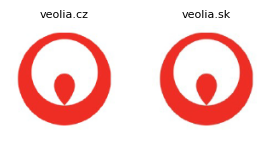

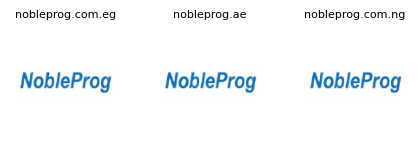

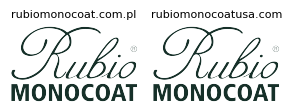

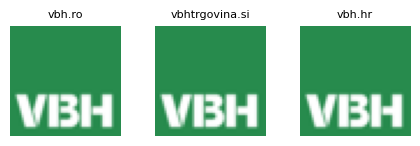

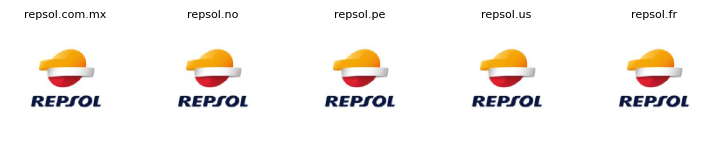

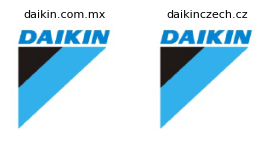

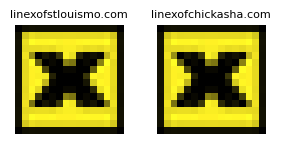

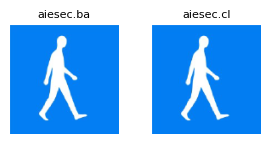

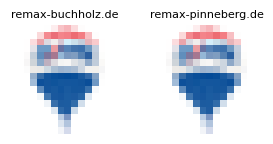

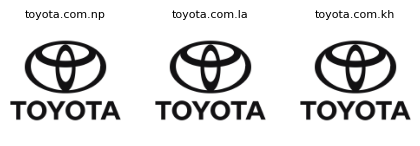

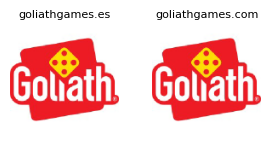

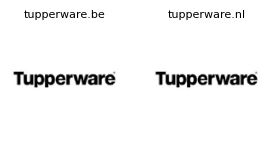

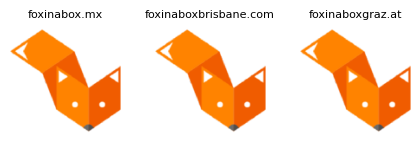

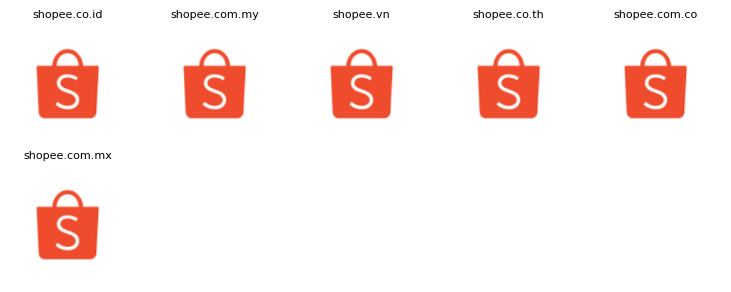

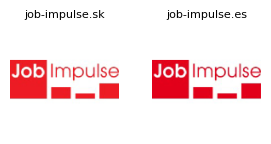

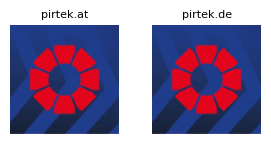

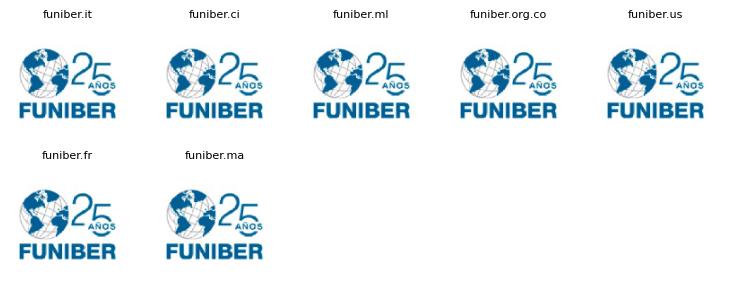

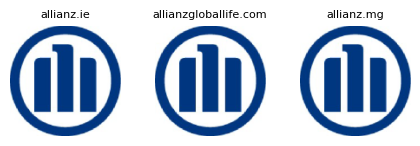

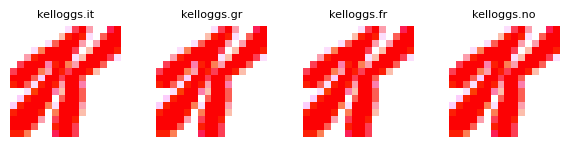

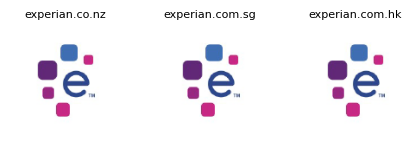

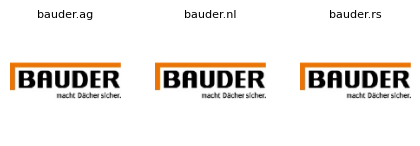

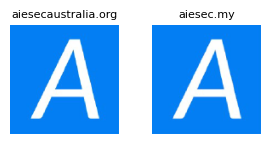

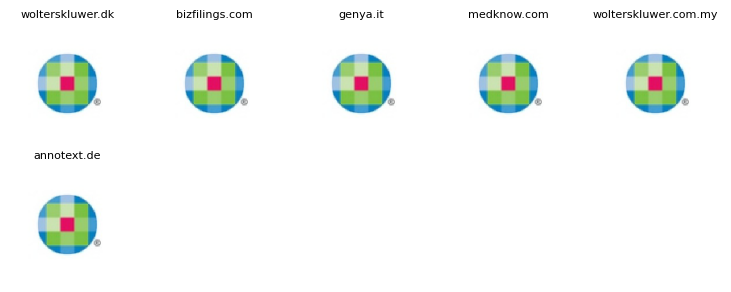

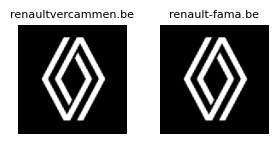

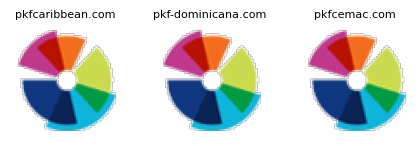

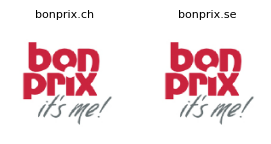

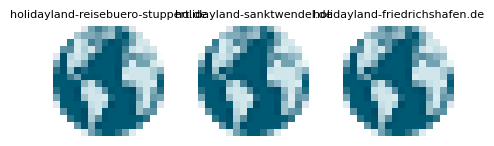

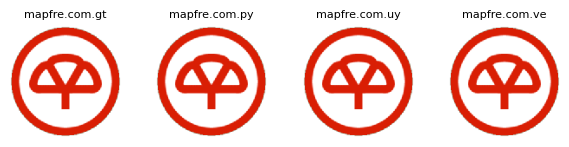

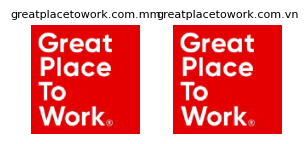

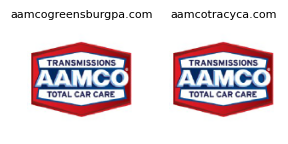

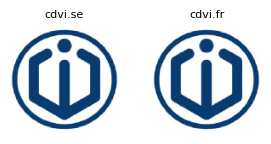

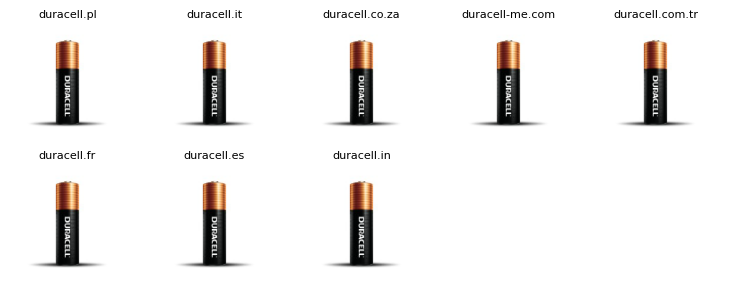

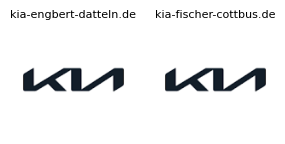

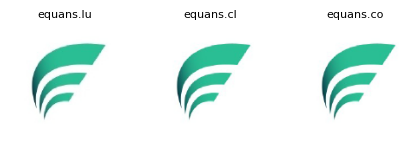

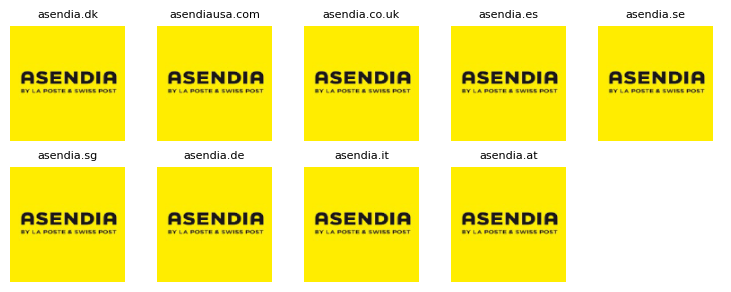

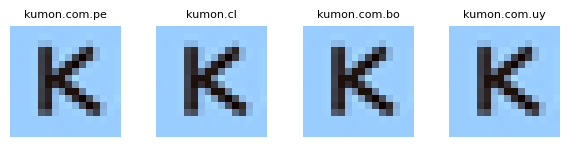

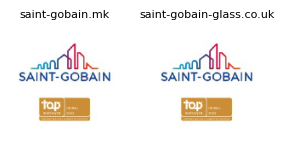

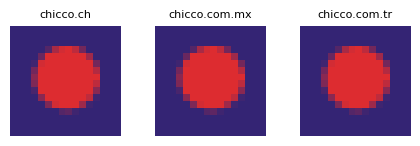

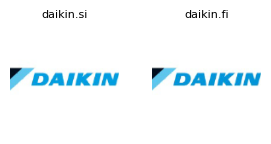

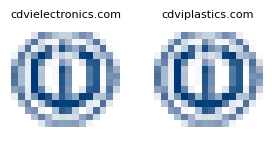

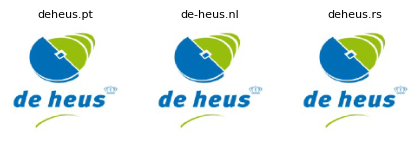

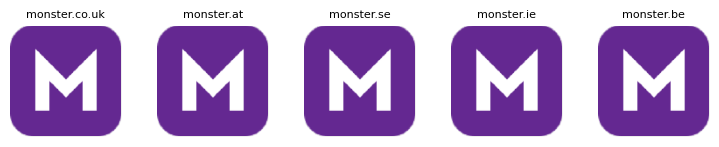

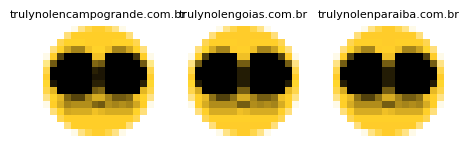

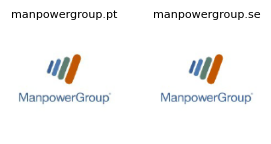

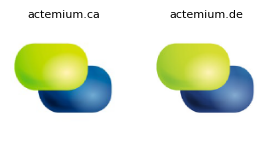

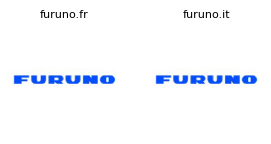

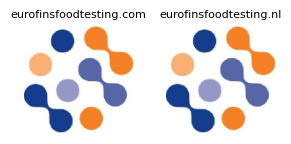

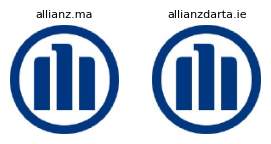

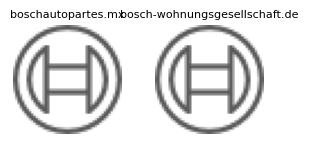

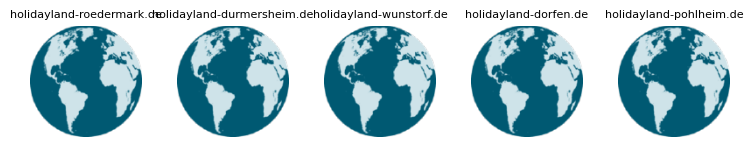

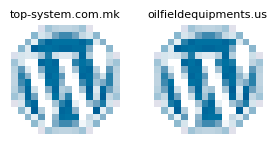

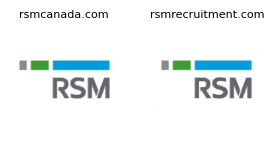

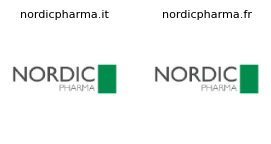

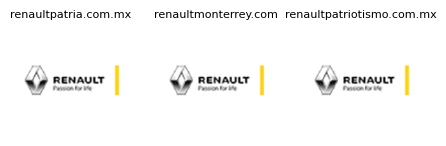

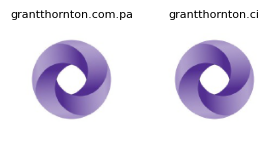

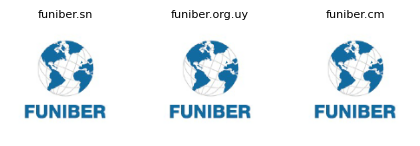

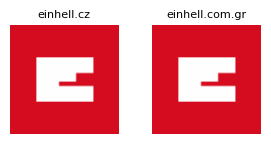

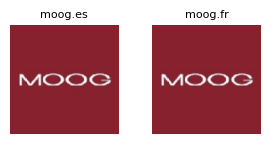

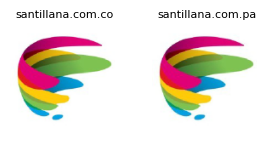

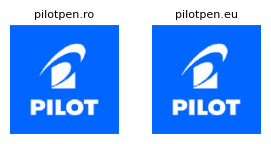

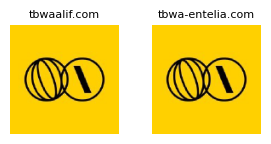

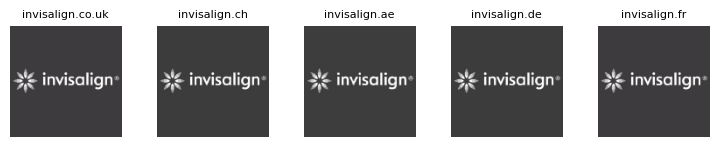

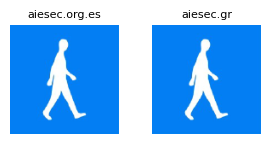

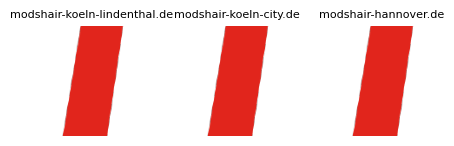

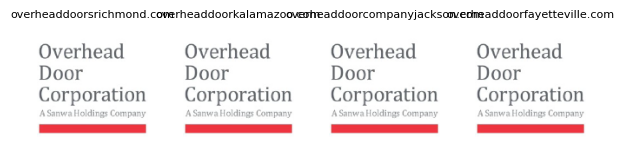

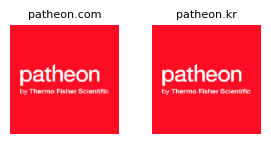

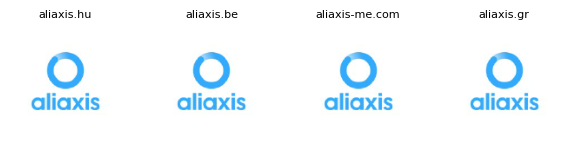

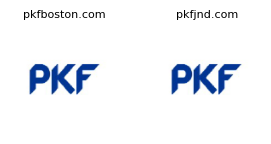

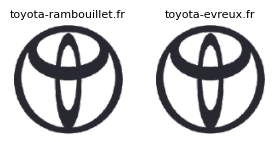

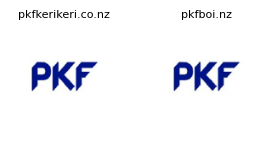

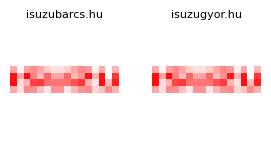

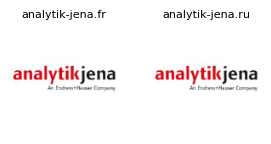

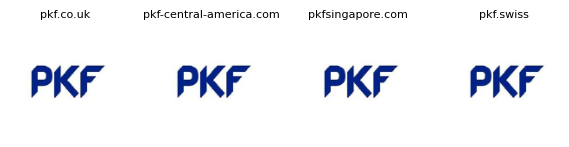

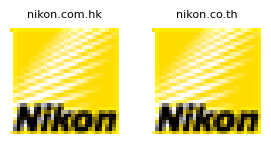

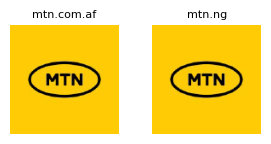

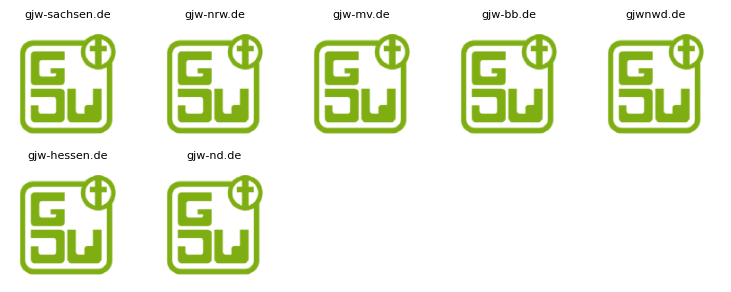

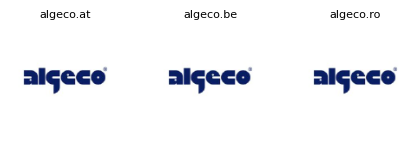

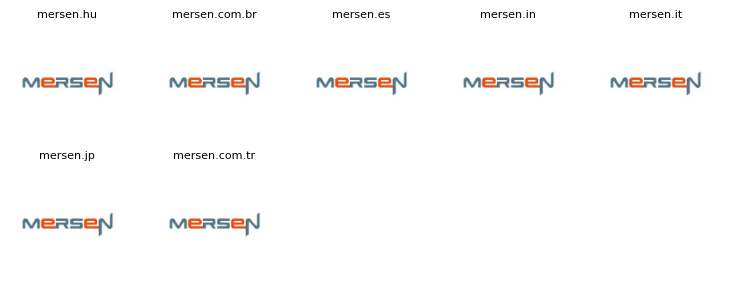

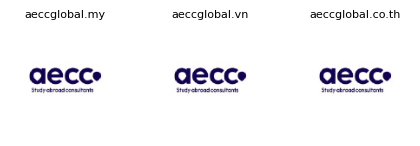

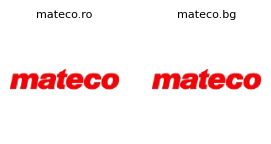

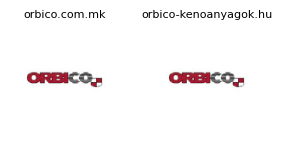

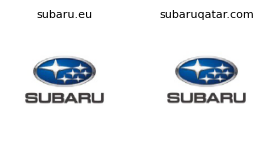

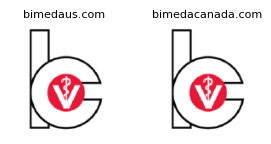

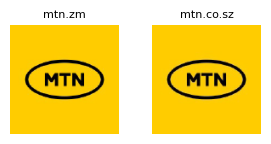

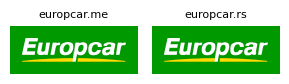

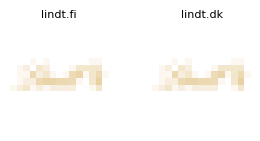

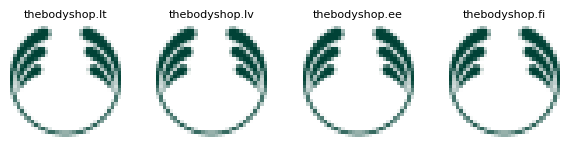

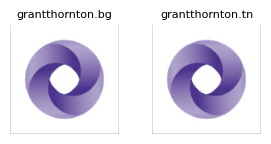

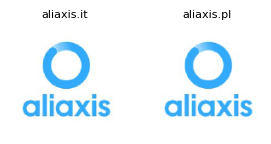

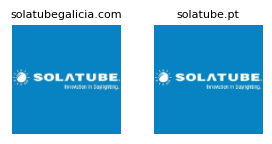

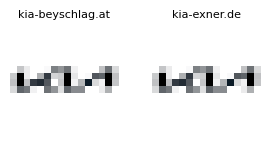

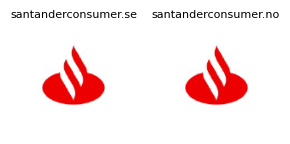

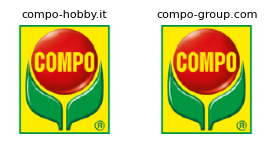

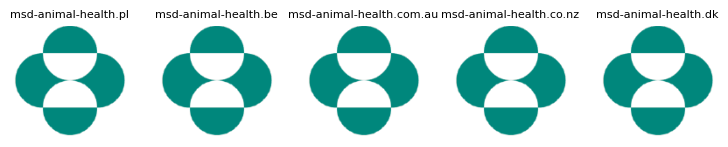

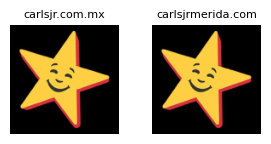

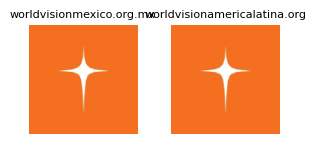

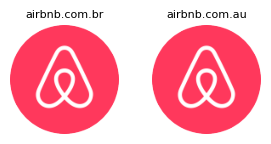

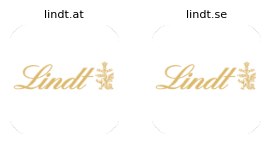

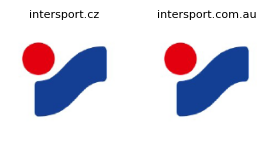

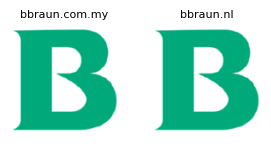

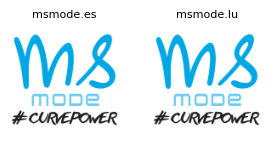

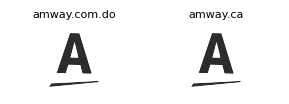

In [34]:
import matplotlib.pyplot as plt
from PIL import Image
import io
import math

# Function to convert image bytes to a PIL image
def bytes_to_image(img_bytes):
    return Image.open(io.BytesIO(img_bytes))

# Filter clusters with at least 2 domains
filtered_clusters = [domains for domains in clusters if len(domains) >= 2]

# Loop through groups to display images dynamically
for domains in filtered_clusters:
    num_images = len(domains)
    
    # Dynamically calculate rows and columns for the grid layout
    cols = min(5, num_images)  # Limit the number of columns to 5 for readability
    rows = math.ceil(num_images / cols)  # Calculate the required rows
    
    # Adjust figure size dynamically
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 1.5, rows * 1.5))  # Adjust size per image
    axes = axes.ravel() if num_images > 1 else [axes]  # Flatten axes if needed

    for i, domain in enumerate(domains):
        if domain in filtered_logos_dict:  # Check if the domain exists in the dictionary
            img = bytes_to_image(filtered_logos_dict[domain])  # Convert image bytes to PIL image
            axes[i].imshow(img)
            axes[i].set_title(domain, fontsize=8)
            axes[i].axis('off')  # Turn off axes
        else:
            print(f"Warning: Domain '{domain}' not found in filtered_logos_dict")

    # Turn off unused axes if fewer images than grid spaces
    for j in range(len(domains), len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()